# Market Price Analysis

This notebook analyzes prices from large markets in Ulaanbaatar, Mongolia from Janaury 2019 to November 2021. The data in this project is updated, but this analysis will be static as it will be used for a post on Mongolian Data Stories.

If you want to see the code used to collect the data for this analysis, see [here](https://deepnote.com/project/UB-Market-Price-Analysis-XCm2UVeZTs-MqI4_J0lh4g/%2FData%20Collection.ipynb).

You can see the complete article I wrote with this analysis at Mongolian Data Stories [here](https://mongoliandatastories.com/UB-Market-Price-Analysis).

Questions I've identified:

- What markets are most/least expensive consistently?
- How did COVID impact prices?
- Is there a sign of psychological pricing?

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime

In [ ]:
plt.style.use('mds.mplstyle')
pd.set_option('display.max_rows', 1000)

In [ ]:
df = pd.read_csv("data/prices_en.csv")

In [ ]:
df.dtypes

date        object
product     object
market      object
size        object
price      float64
dtype: object

In [ ]:
df.head()

date                  product      market size  price
0  2019-01-02  Aleika High Grade Flour        Bars   kg    NaN
1  2019-01-02  Aleika High Grade Flour  Bayanzurkh   kg    NaN
2  2019-01-02  Aleika High Grade Flour    Bumbugur   kg    NaN
3  2019-01-02  Aleika High Grade Flour       Emart   kg    NaN
4  2019-01-02  Aleika High Grade Flour  Kharkhorin   kg    NaN

## Data Cleaning

Change date to a datetime and sort so we can see the date range for our data.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df = df.sort_values(by='date').reset_index(drop=True)

In [ ]:
df.head()

date                  product            market size   price
0 2019-01-02  Aleika High Grade Flour              Bars   kg     NaN
1 2019-01-02           Mutton w/Bones        Max/M Mart   kg  6950.0
2 2019-01-02           Mutton w/Bones  Khuchit Shonkhor   kg  6500.0
3 2019-01-02           Mutton w/Bones        Kharkhorin   kg  6000.0
4 2019-01-02           Mutton w/Bones             Emart   kg  6900.0

In [ ]:
df.tail()

date          product        market   size   price
60679 2021-11-24  Beet, Mongolian      Bumbugur     kg  4000.0
60680 2021-11-24  Beet, Mongolian    Bayanzurkh     kg  3500.0
60681 2021-11-24  Beet, Mongolian          Bars     kg  4500.0
60682 2021-11-24     Egg, Russian        Saruul   each   420.0
60683 2021-11-24           Yogurt  Tavan Erdene  liter  3000.0

Let's translate our names so we can more easily read them.

In [ ]:
df.dtypes

date       datetime64[ns]
product            object
market             object
size               object
price             float64
dtype: object

In [ ]:
df.sample(2)

date                                 product      market size  \
1234  2019-01-16                           Beef Boneless      Sansar   kg   
50927 2021-06-08  Altan Taria Packaged Flour, High Grade  Kharkhorin   kg   

        price  
1234      NaN  
50927  1600.0

## 0. Which markets have which products?

First we should determine which markets regularly carry each product. Because we have a large number of products and markets we could perhaps build a heatmap.

In [ ]:
df.shape

(60684, 5)

In [ ]:
df['product'].unique()

array(['Aleika High Grade Flour', 'Mutton w/Bones', 'Mutton Boneless',
       'Milk, Bulk', 'Potato, Mongolian', 'Onion, China',
       'Gree Tea, Georgia', 'Goat Meat w/Bones', 'Egg, Russian',
       'Horse Meat w/Bones', 'White Rice', 'Vegatable Oil', 'Yellow Rice',
       'Yogurt', 'Suu Brand Milk, 1l', 'Sugar',
       'Round Bread, Czech Style', 'Suu Brand Milk, 0.5l',
       'Altan Taria Packaged Flour, High Grade',
       'Altan Taria Packaged Flour, 2nd Grade',
       'Altan Taria Packaged Flour, Top Grade', 'Atar Brand Bread',
       'Apple, Fuji', 'Altan Taria Packaged Flour, 1st Grade',
       'Altan Taria Flour, First Grade', 'Altan Taria Flour, High Grade',
       'Cabbage, Mongolian', 'Butter, Suu LTD', 'Brown Bread',
       'Carrot, Mongolian', 'Beef w/Bones', 'Beef Boneless',
       'Beet, Mongolian', 'Reserve meat, beef w/bones',
       'Reserve meat, goat w/bones', 'Reserve meat, mutton w/bones'],
      dtype=object)

In [ ]:
heatmap = (df.
           groupby(by=['market','product'])
           .count()
           .reset_index()
           .pivot(index='market', columns='product', values='price') 
           / len(df['date'].unique()))

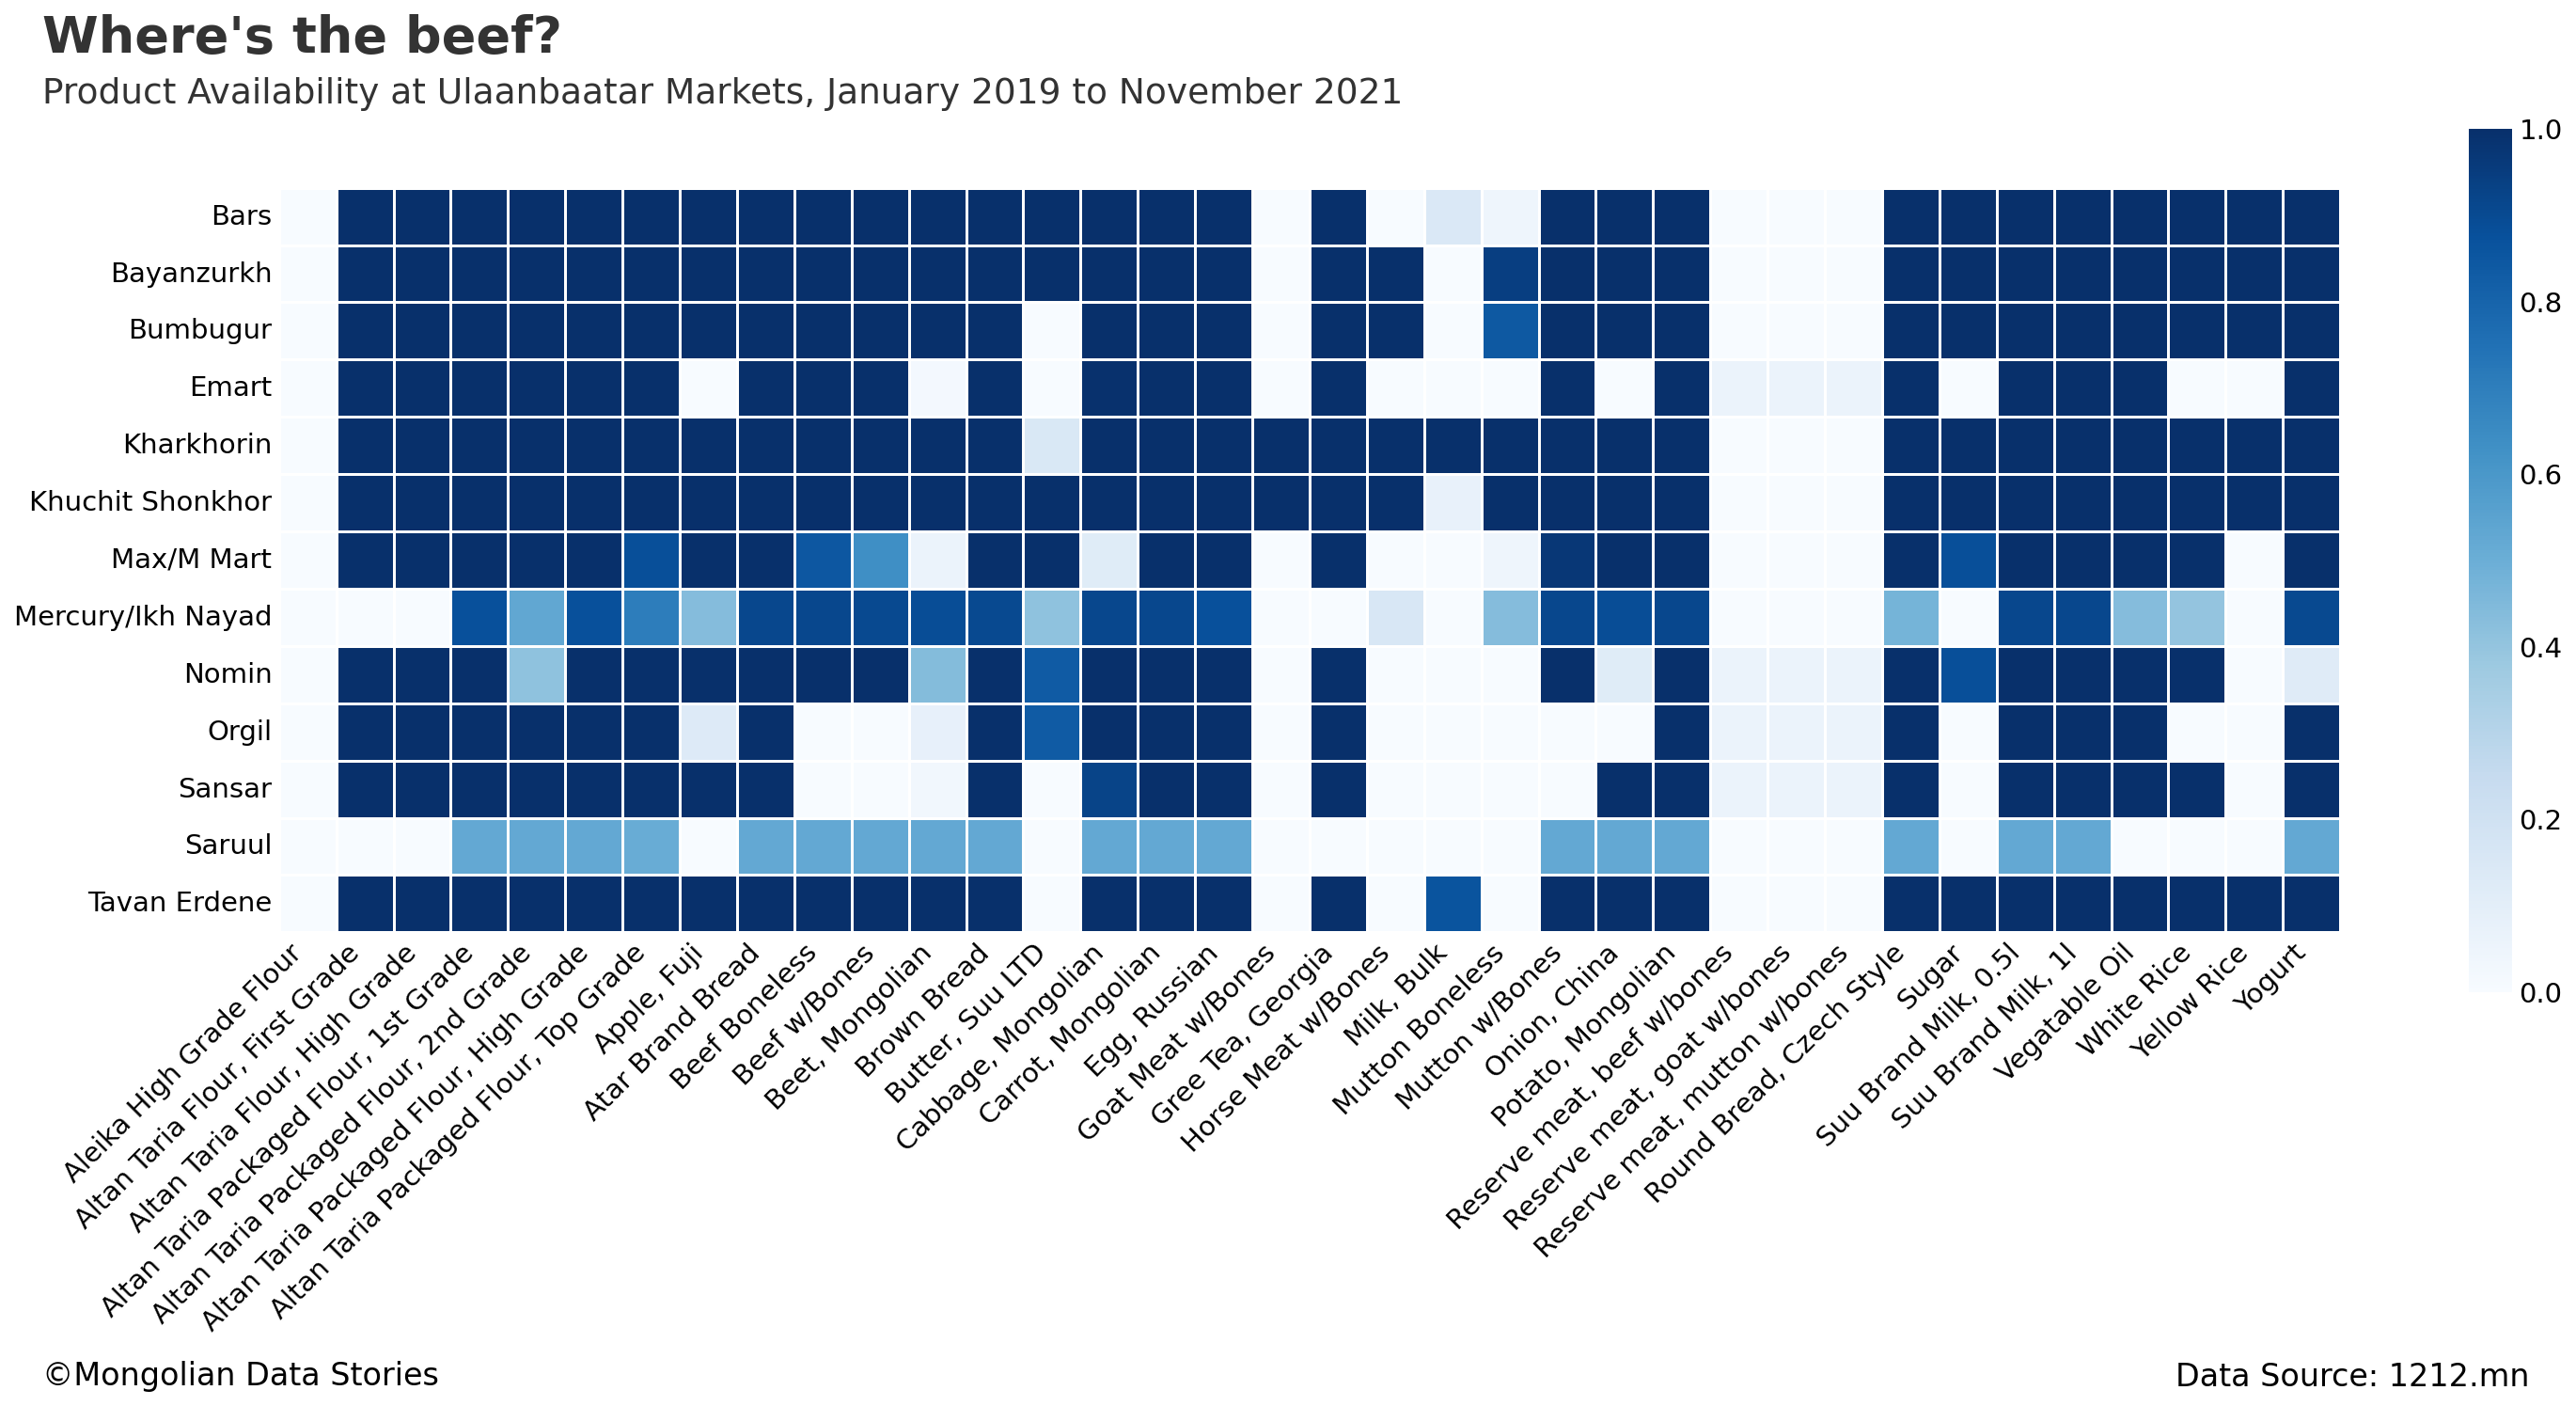

In [ ]:
fig, ax = plt.subplots(figsize=(21,9))
sns.heatmap(heatmap, ax=ax, cmap='Blues', linewidths=0.5, square=True)

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Remove axis labels
ax.set_ylabel('')    
ax.set_xlabel('')

# Set title and subtitle
ax.text(x=0, y=.94, s="Where's the beef?", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0, y=.90, s="Product Availability at Ulaanbaatar Markets, January 2019 to November 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0, y = -.11, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16, )
ax.text(x = .84, y = -.11, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/product_availability.png', dpi = 300, bbox_inches="tight")

## 1. What markets are most/least expensive consistently?

Of course the first question on most people's mind is, which markets have the most or least expensive products? There are several products that are very similar, such as different types of flour, that make the analysis a bit complicated. To make things simpler I will choose a few products that are very common:

To show this I will build a plot for each product, comparing prices for each product.

In [ ]:
np.sort(df['product'].unique())

array(['Aleika High Grade Flour', 'Altan Taria Flour, First Grade',
       'Altan Taria Flour, High Grade',
       'Altan Taria Packaged Flour, 1st Grade',
       'Altan Taria Packaged Flour, 2nd Grade',
       'Altan Taria Packaged Flour, High Grade',
       'Altan Taria Packaged Flour, Top Grade', 'Apple, Fuji',
       'Atar Brand Bread', 'Beef Boneless', 'Beef w/Bones',
       'Beet, Mongolian', 'Brown Bread', 'Butter, Suu LTD',
       'Cabbage, Mongolian', 'Carrot, Mongolian', 'Egg, Russian',
       'Goat Meat w/Bones', 'Gree Tea, Georgia', 'Horse Meat w/Bones',
       'Milk, Bulk', 'Mutton Boneless', 'Mutton w/Bones', 'Onion, China',
       'Potato, Mongolian', 'Reserve meat, beef w/bones',
       'Reserve meat, goat w/bones', 'Reserve meat, mutton w/bones',
       'Round Bread, Czech Style', 'Sugar', 'Suu Brand Milk, 0.5l',
       'Suu Brand Milk, 1l', 'Vegatable Oil', 'White Rice', 'Yellow Rice',
       'Yogurt'], dtype=object)

In [ ]:
product_list = ['Suu Brand Milk, 1l',
                'Egg, Russian',
                'Potato, Mongolian',
                'Carrot, Mongolian',
                'White Rice',
                'Atar Brand Bread', 
                'Beef w/Bones',
                'Mutton w/Bones']

In [ ]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

### Failed attempt to make an easy to read line plot

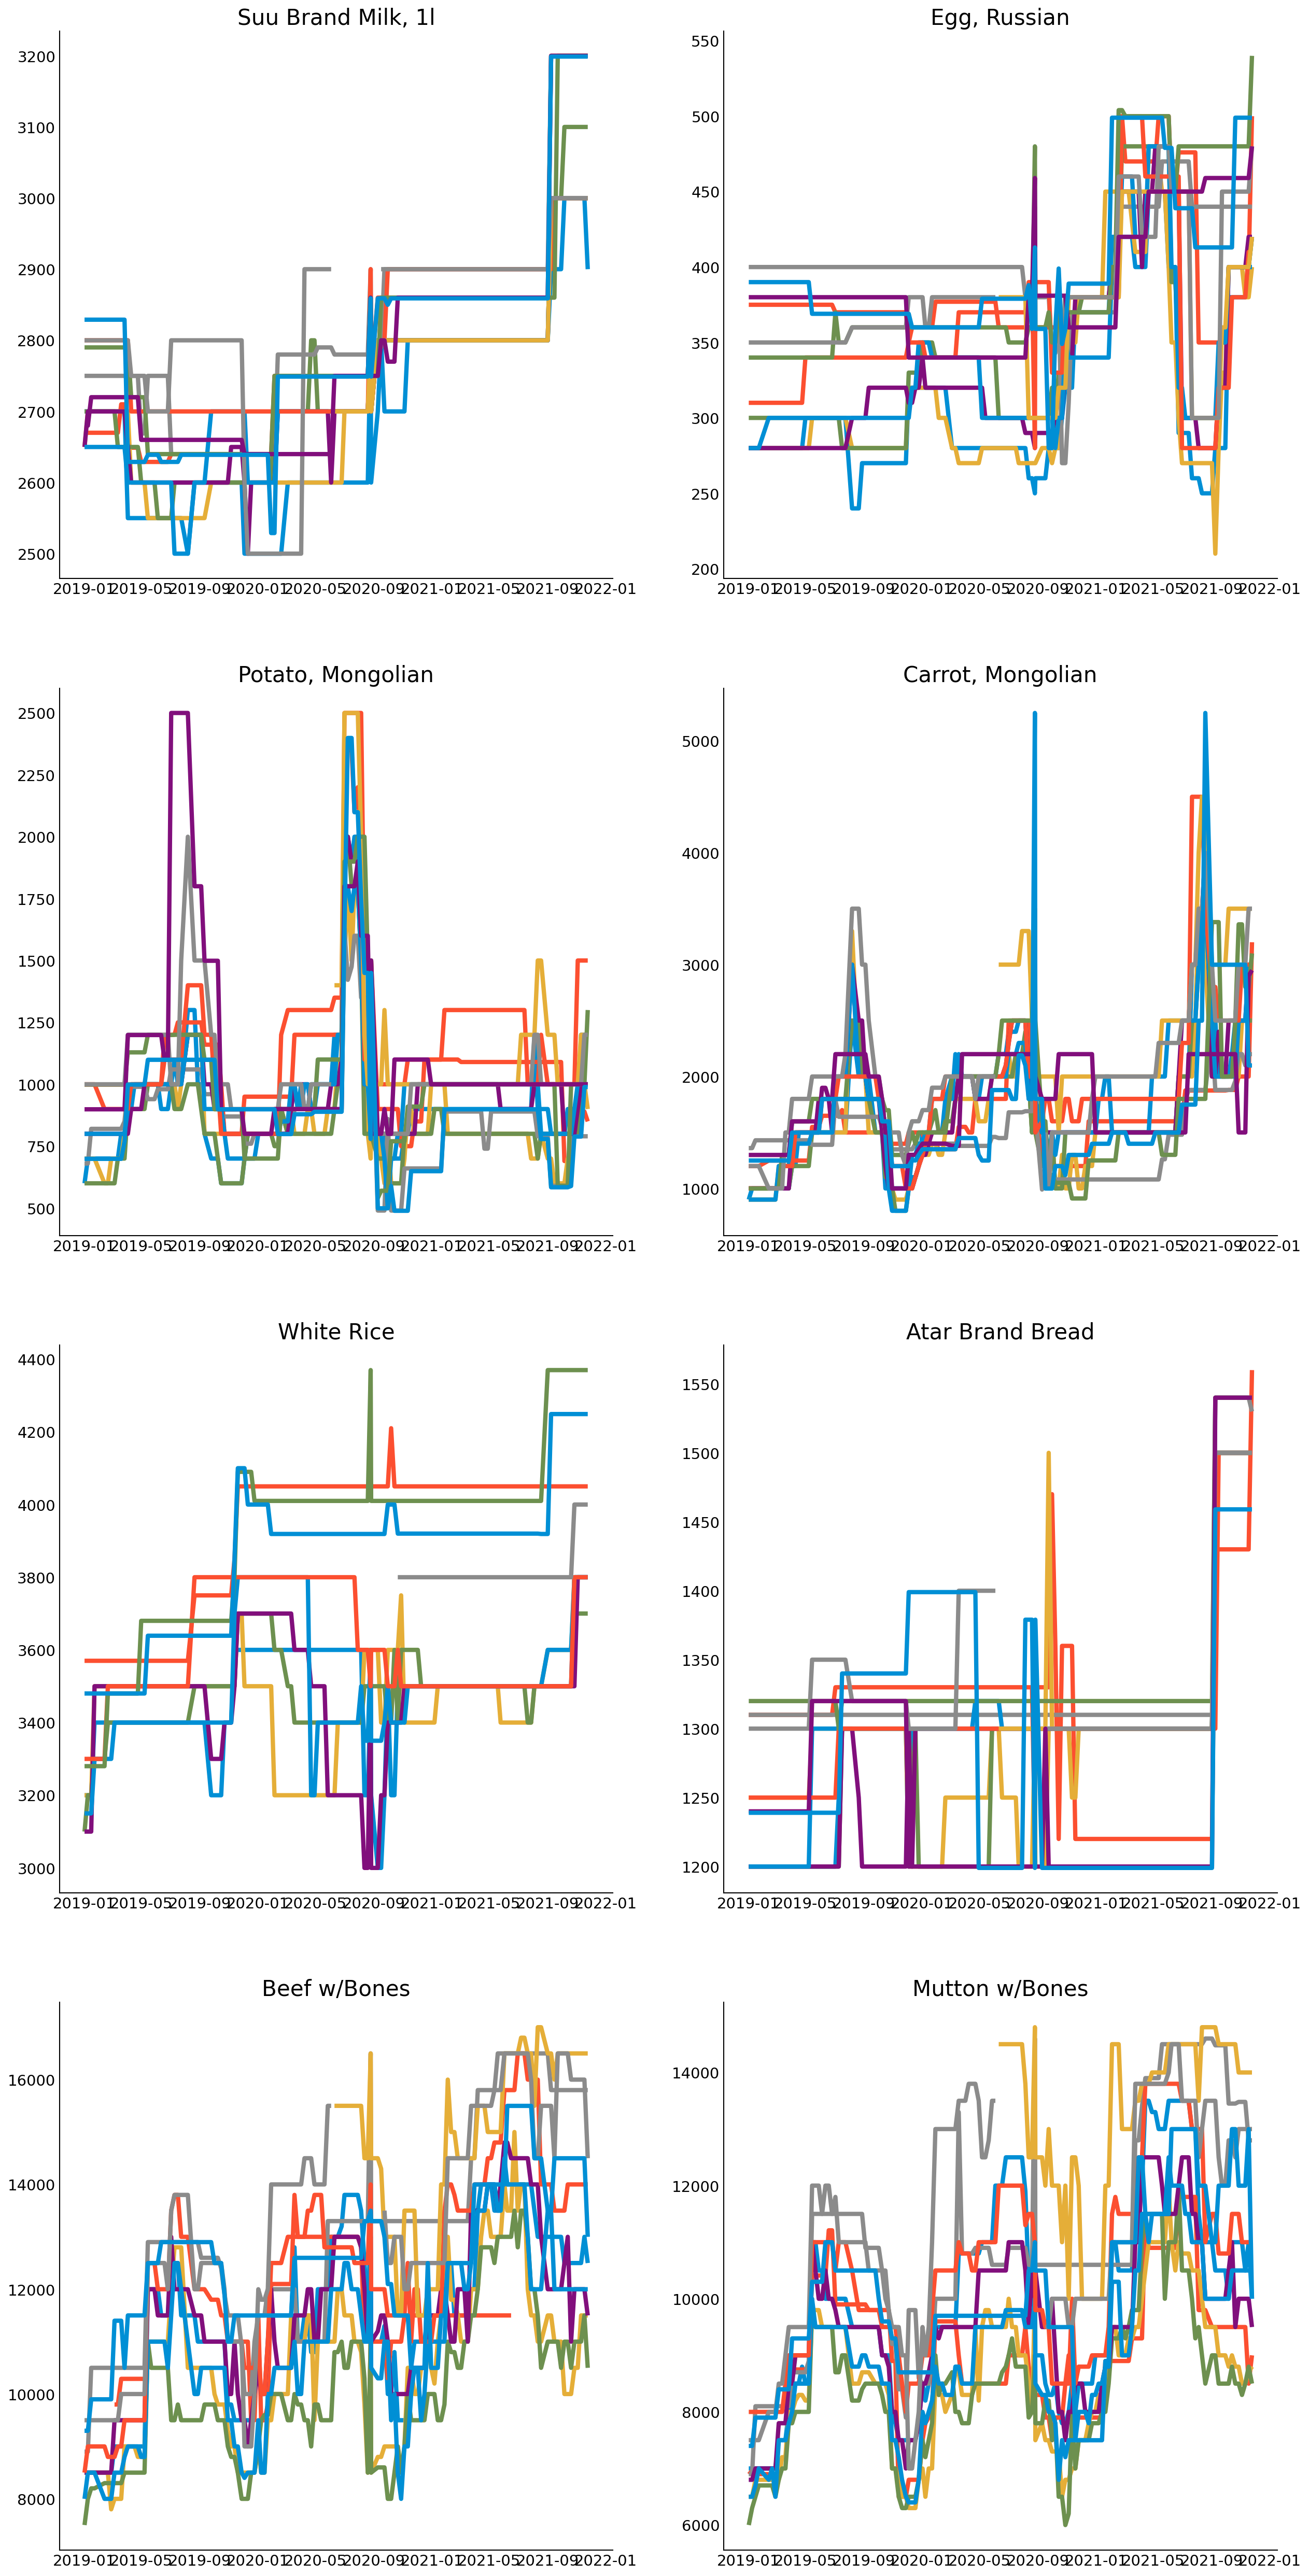

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(18,40))

# The plot now is missing tick labels on the subplots. Let's add them back.
for ax in fig.axes:
    # Add missing tick labels
    ax.tick_params(axis='both', which='major', bottom=True, left=True, labelbottom=True,  labelleft=True)
    # Set xlim and ylim
    #ax.set_ylim(0, round(filtered_df['price'].max(), -3))
    #ax.set_xlim(filtered_df['date'].min(), filtered_df['date'].max())


# Loop through products to make the plots  
for product, ax in zip(product_list, fig.axes):
    for market in df['market'].unique():
        x = df[(df['market'] == market) & (df['product'] == product)]['date']
        y = df[(df['market'] == market) & (df['product'] == product)]['price']
        ax.plot(x, y, label=market)
        ax.title.set_text(product)
        
# Set legend for entire plot
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(labels);

# Save image
#plt.savefig('images/product_timeseries.png', dpi = 300, bbox_inches="tight")

Well this isn't as clear as I hoped. The prices mix around quite a lot between the markets. There is a clear difference between the high and low end of the market, but there is also a lot of price crossover. 

Let's take a different approach and instead make a plot for each product individually so we can see more of what is happening. Instead of showing the time series I will take two dates, one from 2019 and one from 2021 and show the change. We will use a dumbbell plot as this can show the change with less noise.

### Сүү ХК 1л - Suu Brand Milk, 1L

In [ ]:
df['market'].unique()

array(['Bars', 'Max/M Mart', 'Khuchit Shonkhor', 'Kharkhorin', 'Emart',
       'Bumbugur', 'Bayanzurkh', 'Tavan Erdene', 'Saruul', 'Sansar',
       'Mercury/Ikh Nayad', 'Orgil', 'Nomin'], dtype=object)

In [ ]:
market_order = {'Khuchit Shonkhor':0, 'Kharkhorin':1, 'Bars':2 , 'Bayanzurkh': 3, 
                'Bumbugur': 4,  'Tavan Erdene': 5, 'Mercury/Ikh Nayad': 6, 'Ikh Nayad': 7, 
                'Saruul': 8, 'Sansar': 9, 'Emart': 10, 'Max/M Mart': 11, 'Nomin': 12, 'Orgil': 13}

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


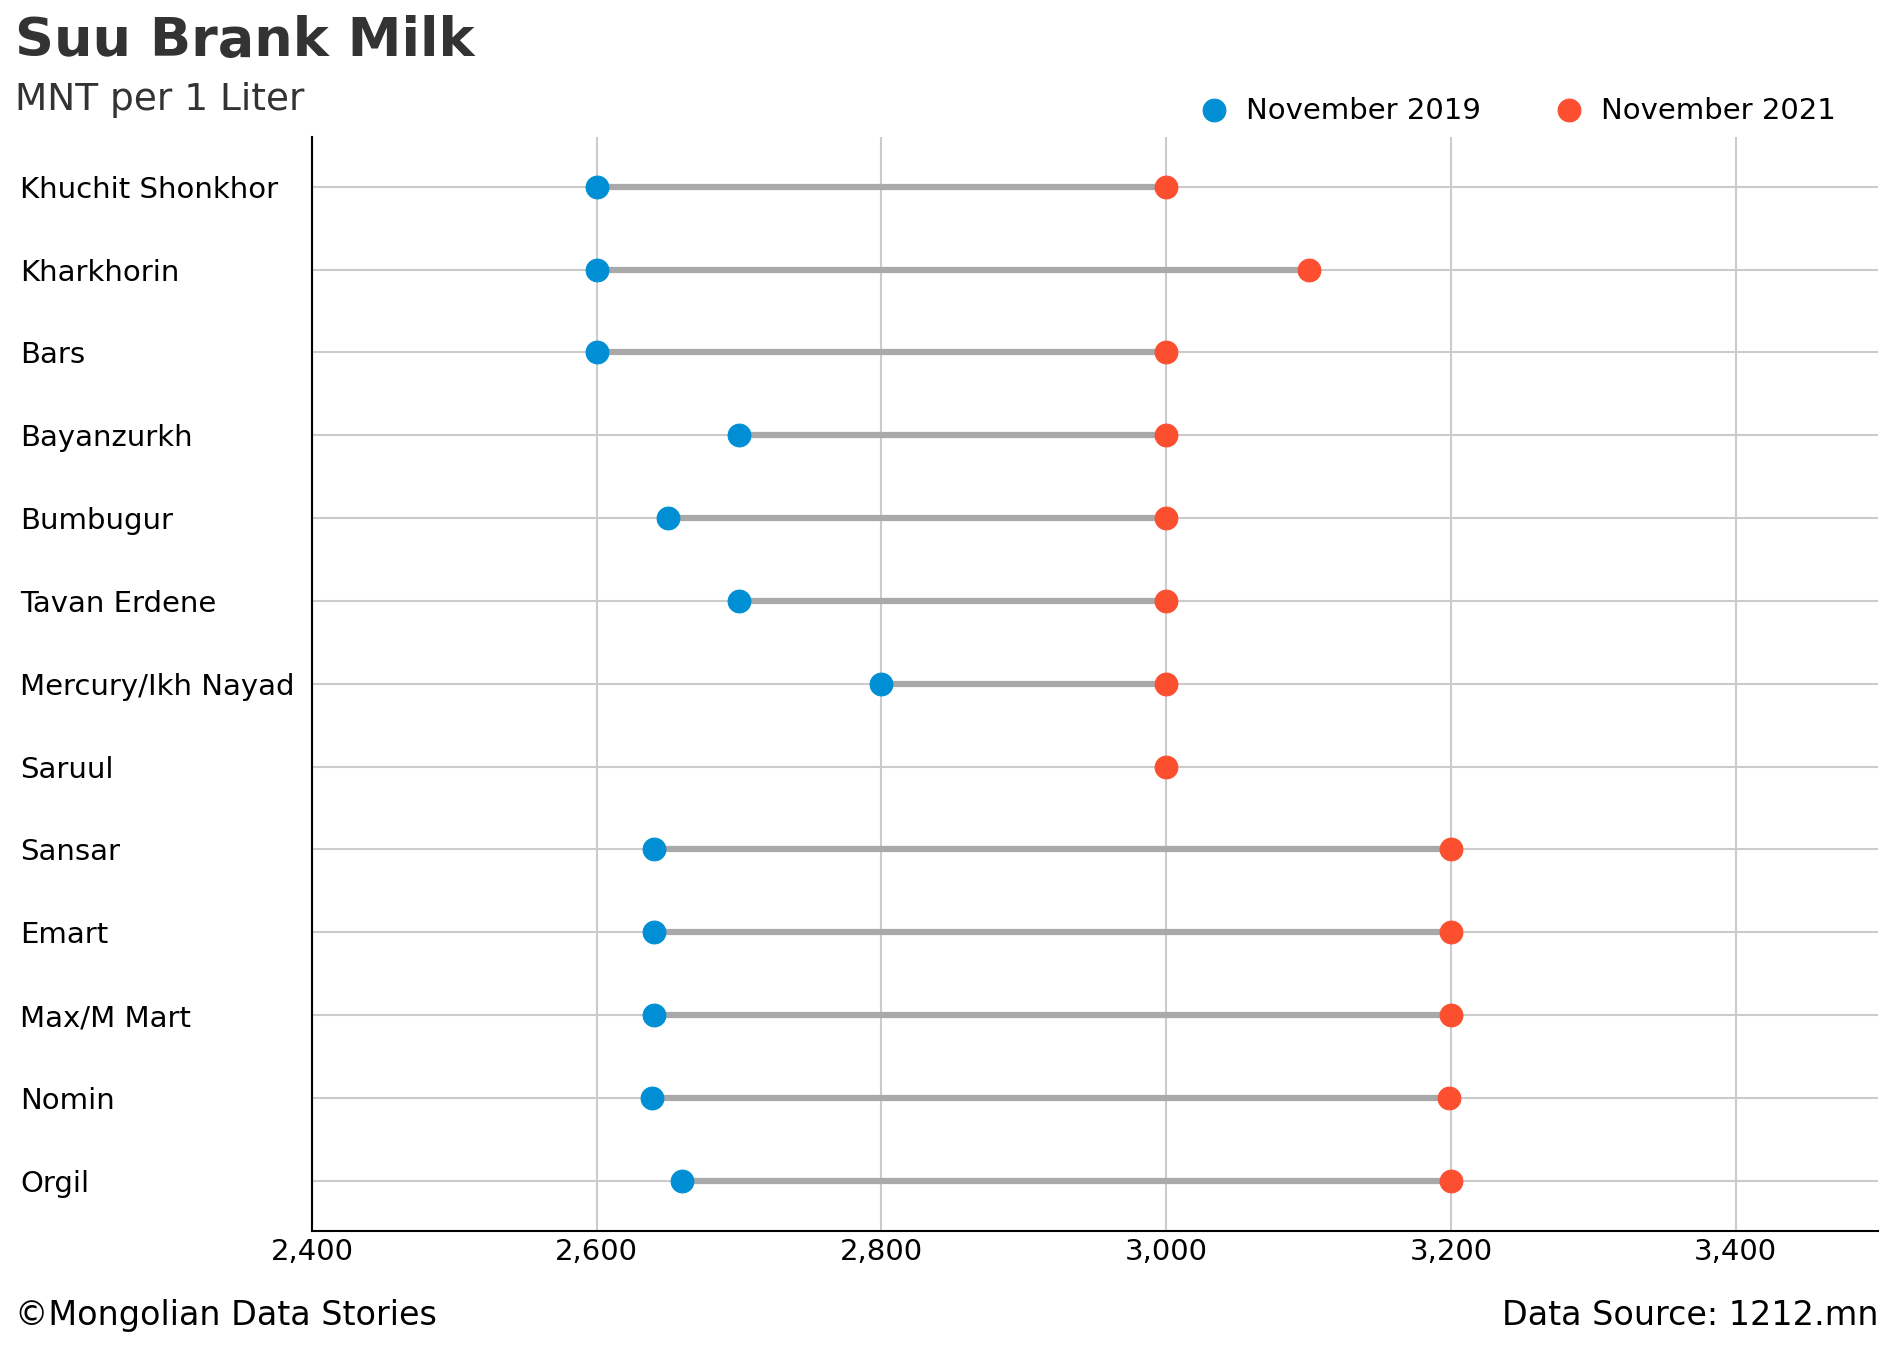

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Suu Brand Milk, 1l'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(2400, 3500)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Suu Brank Milk", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per 1 Liter", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/milk_dumbbell.png', dpi = 300, bbox_inches="tight")

### Өндөг, ОХУ - Russian Eggs

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


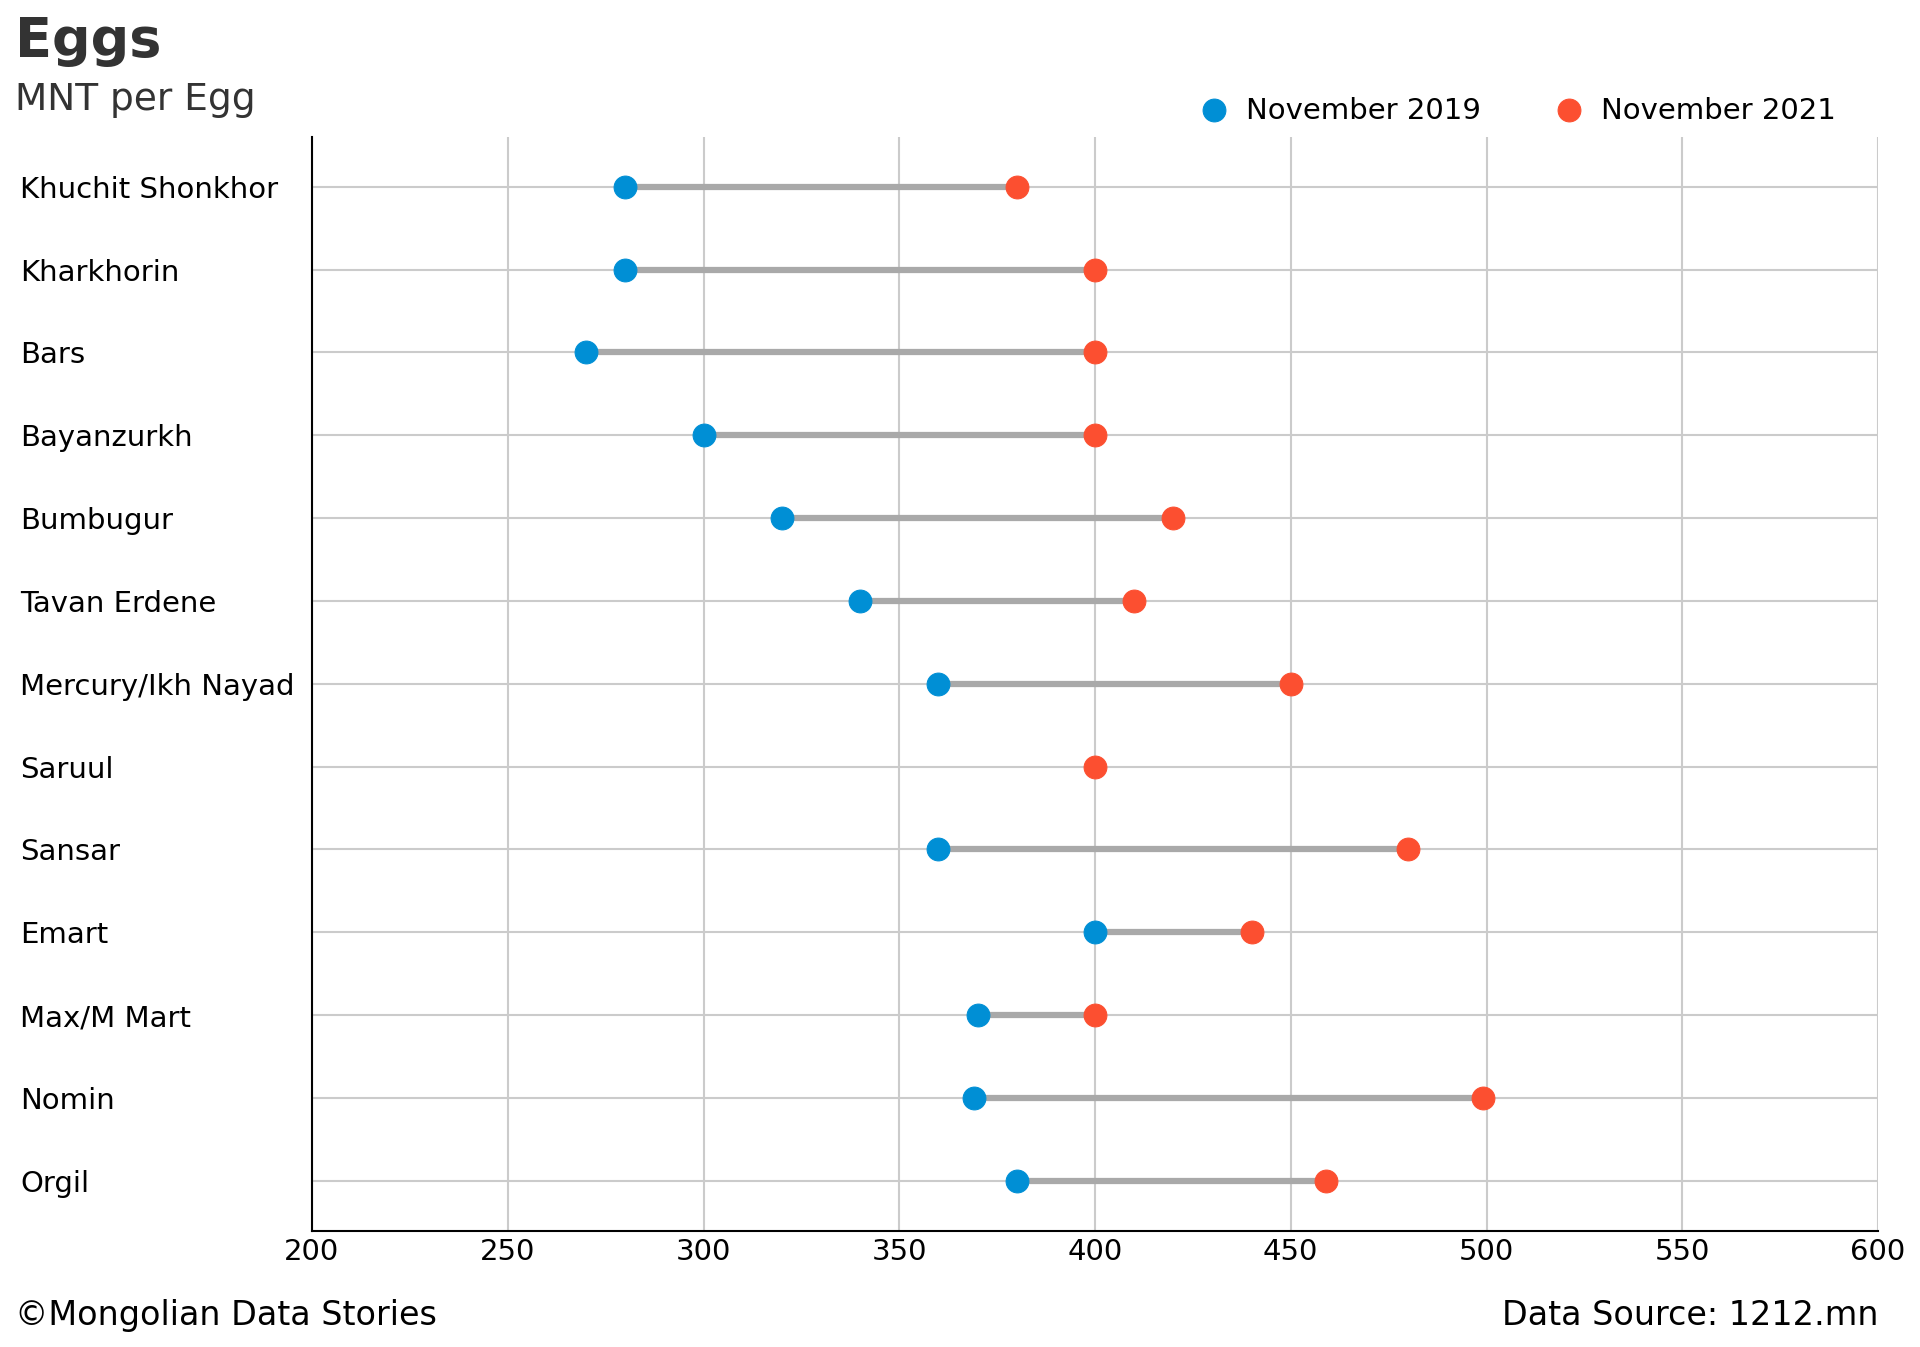

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Egg, Russian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = (df[(df['product'] == product) & 
                 ((df['date'] == date1) | 
                 (df['date'] == date2))][['market','date','price']]
              .pivot(index='market',columns='date', values='price'))
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, 
          xmin=product_df[date1], 
          xmax=product_df[date2], 
          color='darkgrey', 
          zorder=1, 
          linewidth=3, 
          label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(200, 600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Eggs", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per Egg", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/eggs_dumbbell.png', dpi = 300, bbox_inches="tight")

### Төмс, монгол - Mongolian Potatos

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


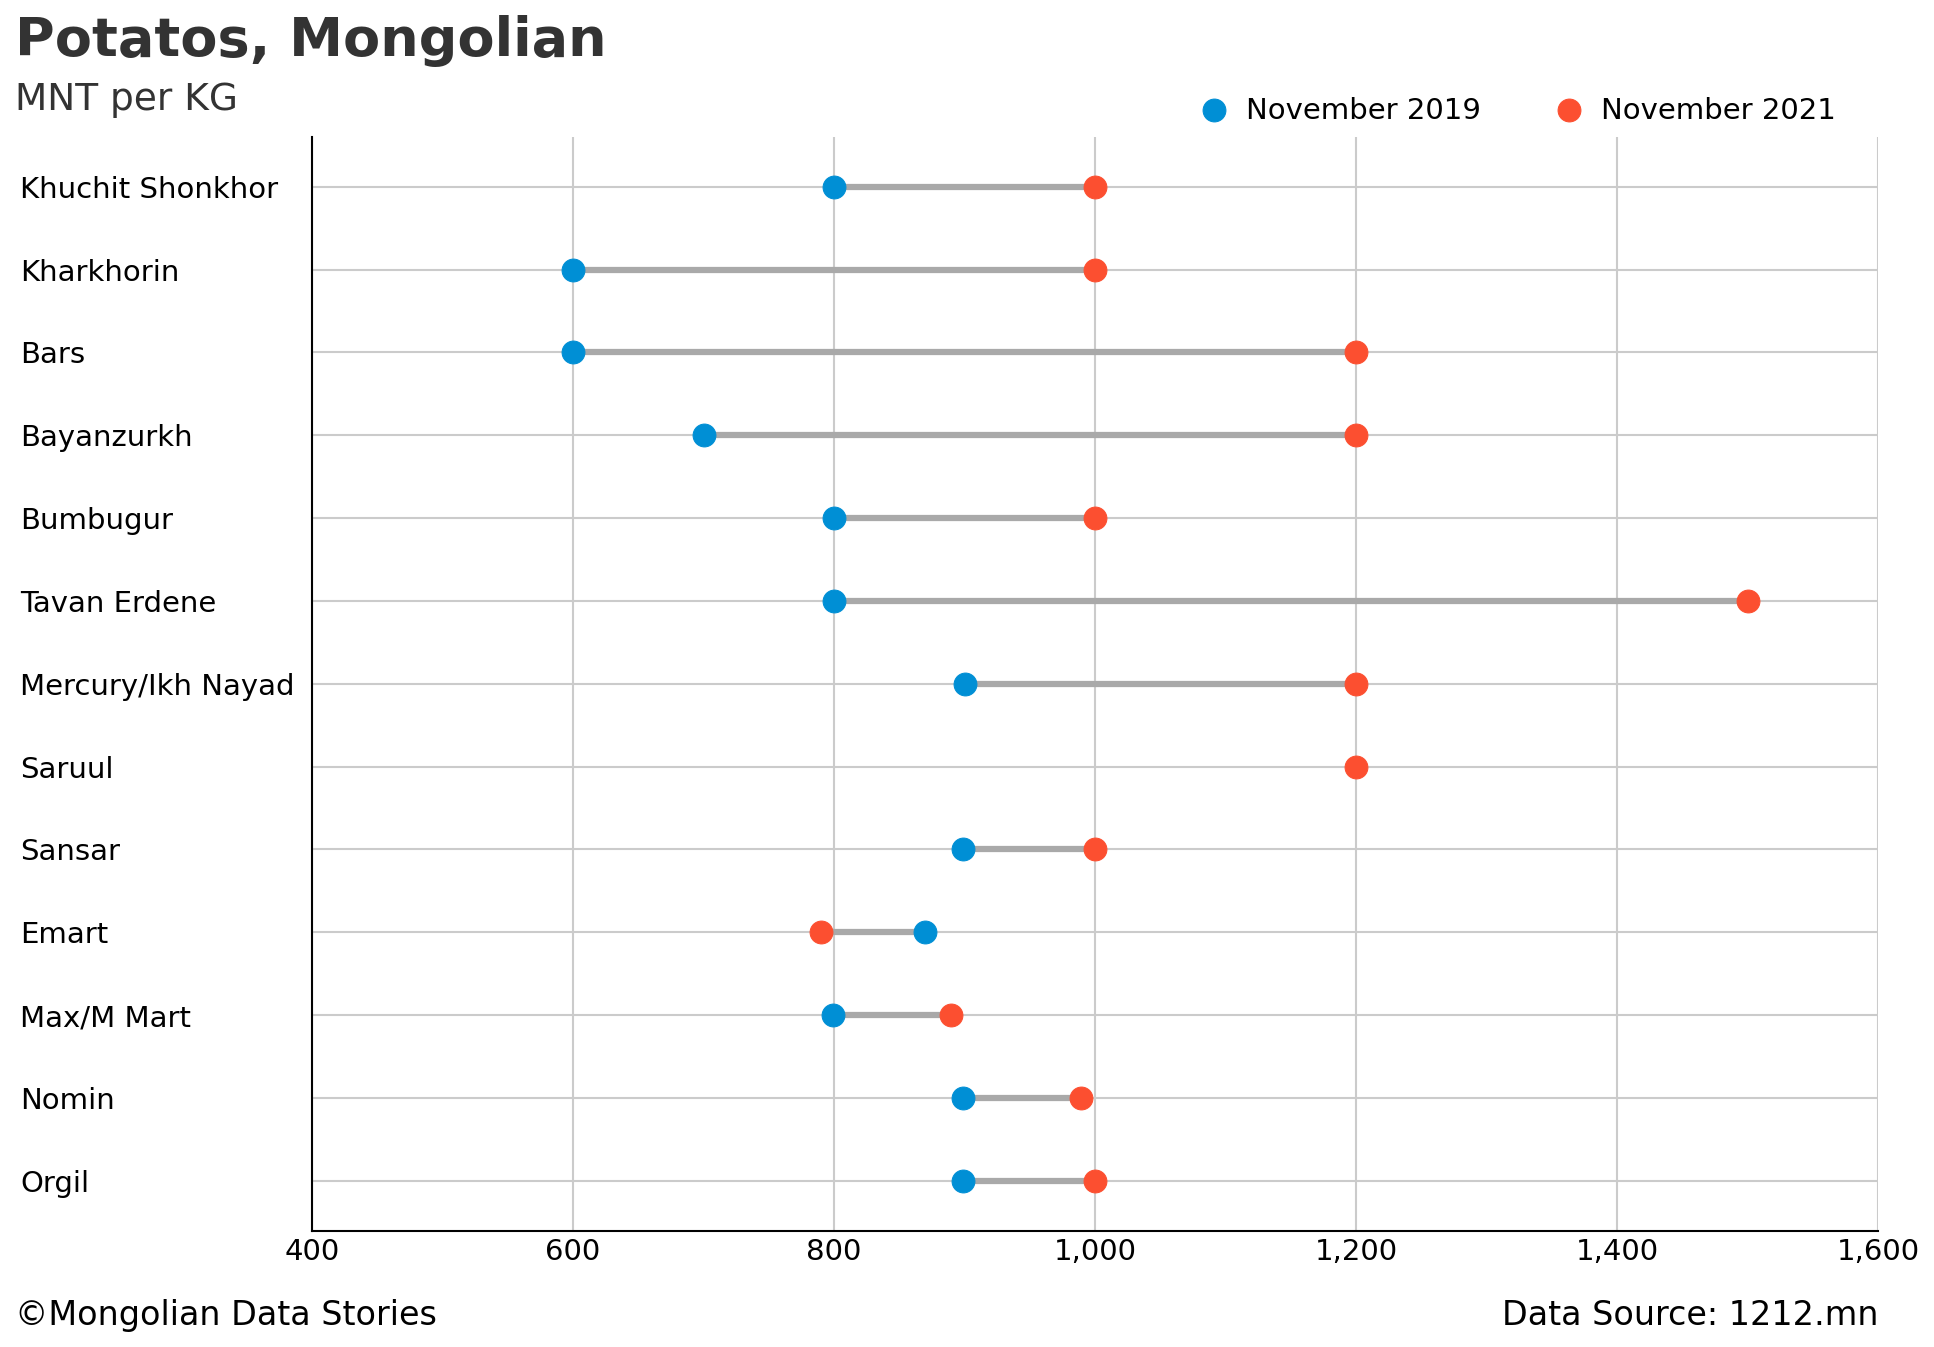

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Potato, Mongolian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(400, 1600)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Potatos, Mongolian", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per KG", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/potato_dumbbell.png', dpi = 300, bbox_inches="tight")

### Лууван, монгол - Carrots, Mongolian

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


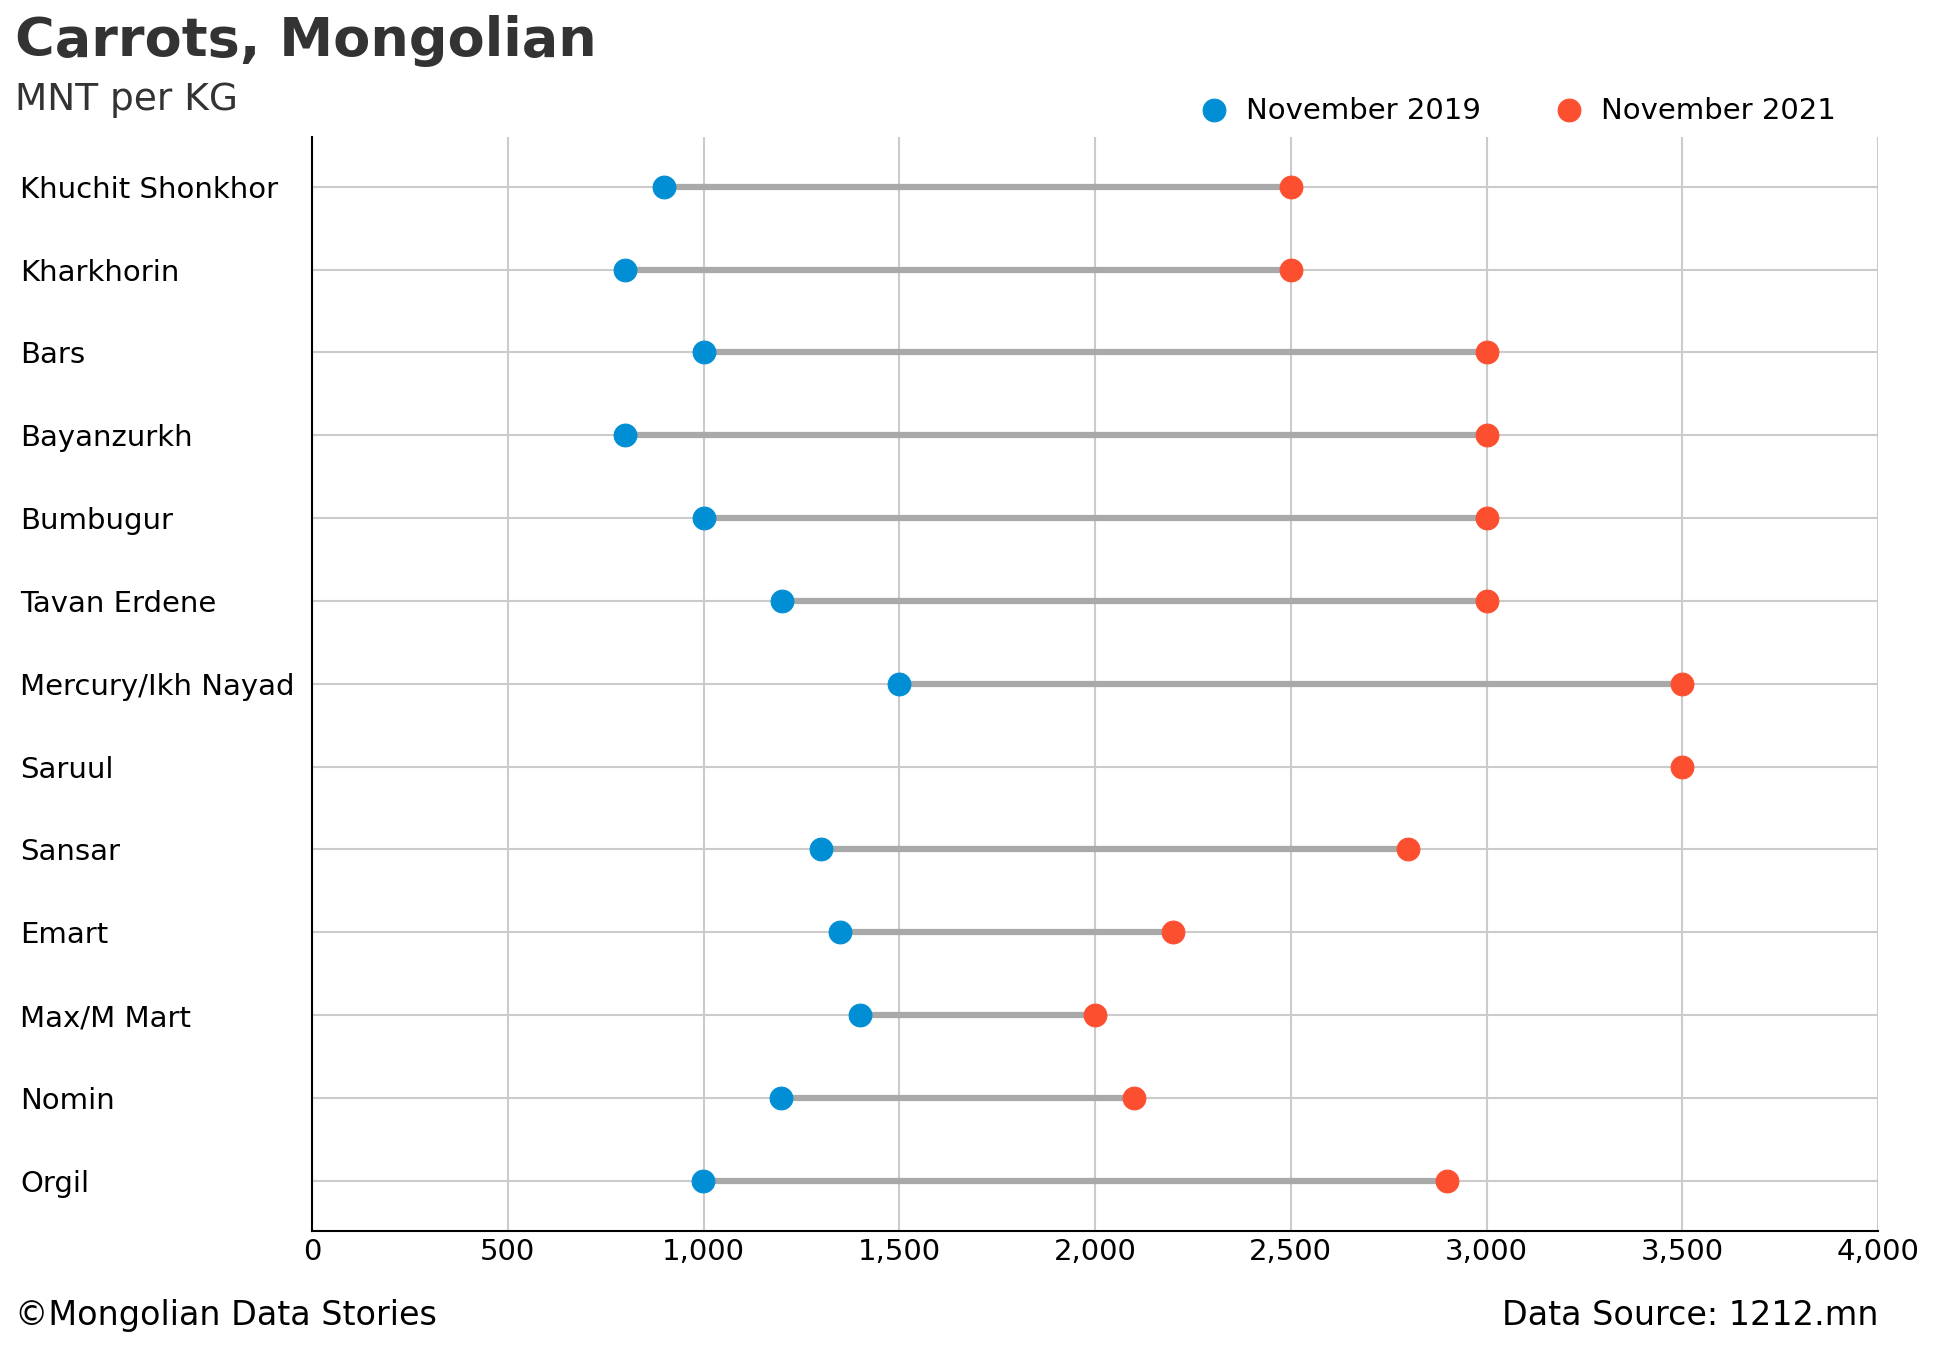

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Carrot, Mongolian'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(0, 4000)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Carrots, Mongolian", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per KG", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/carrots_dumbbell.png', dpi = 300, bbox_inches="tight")

### Будаа цагаан - White Rice

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


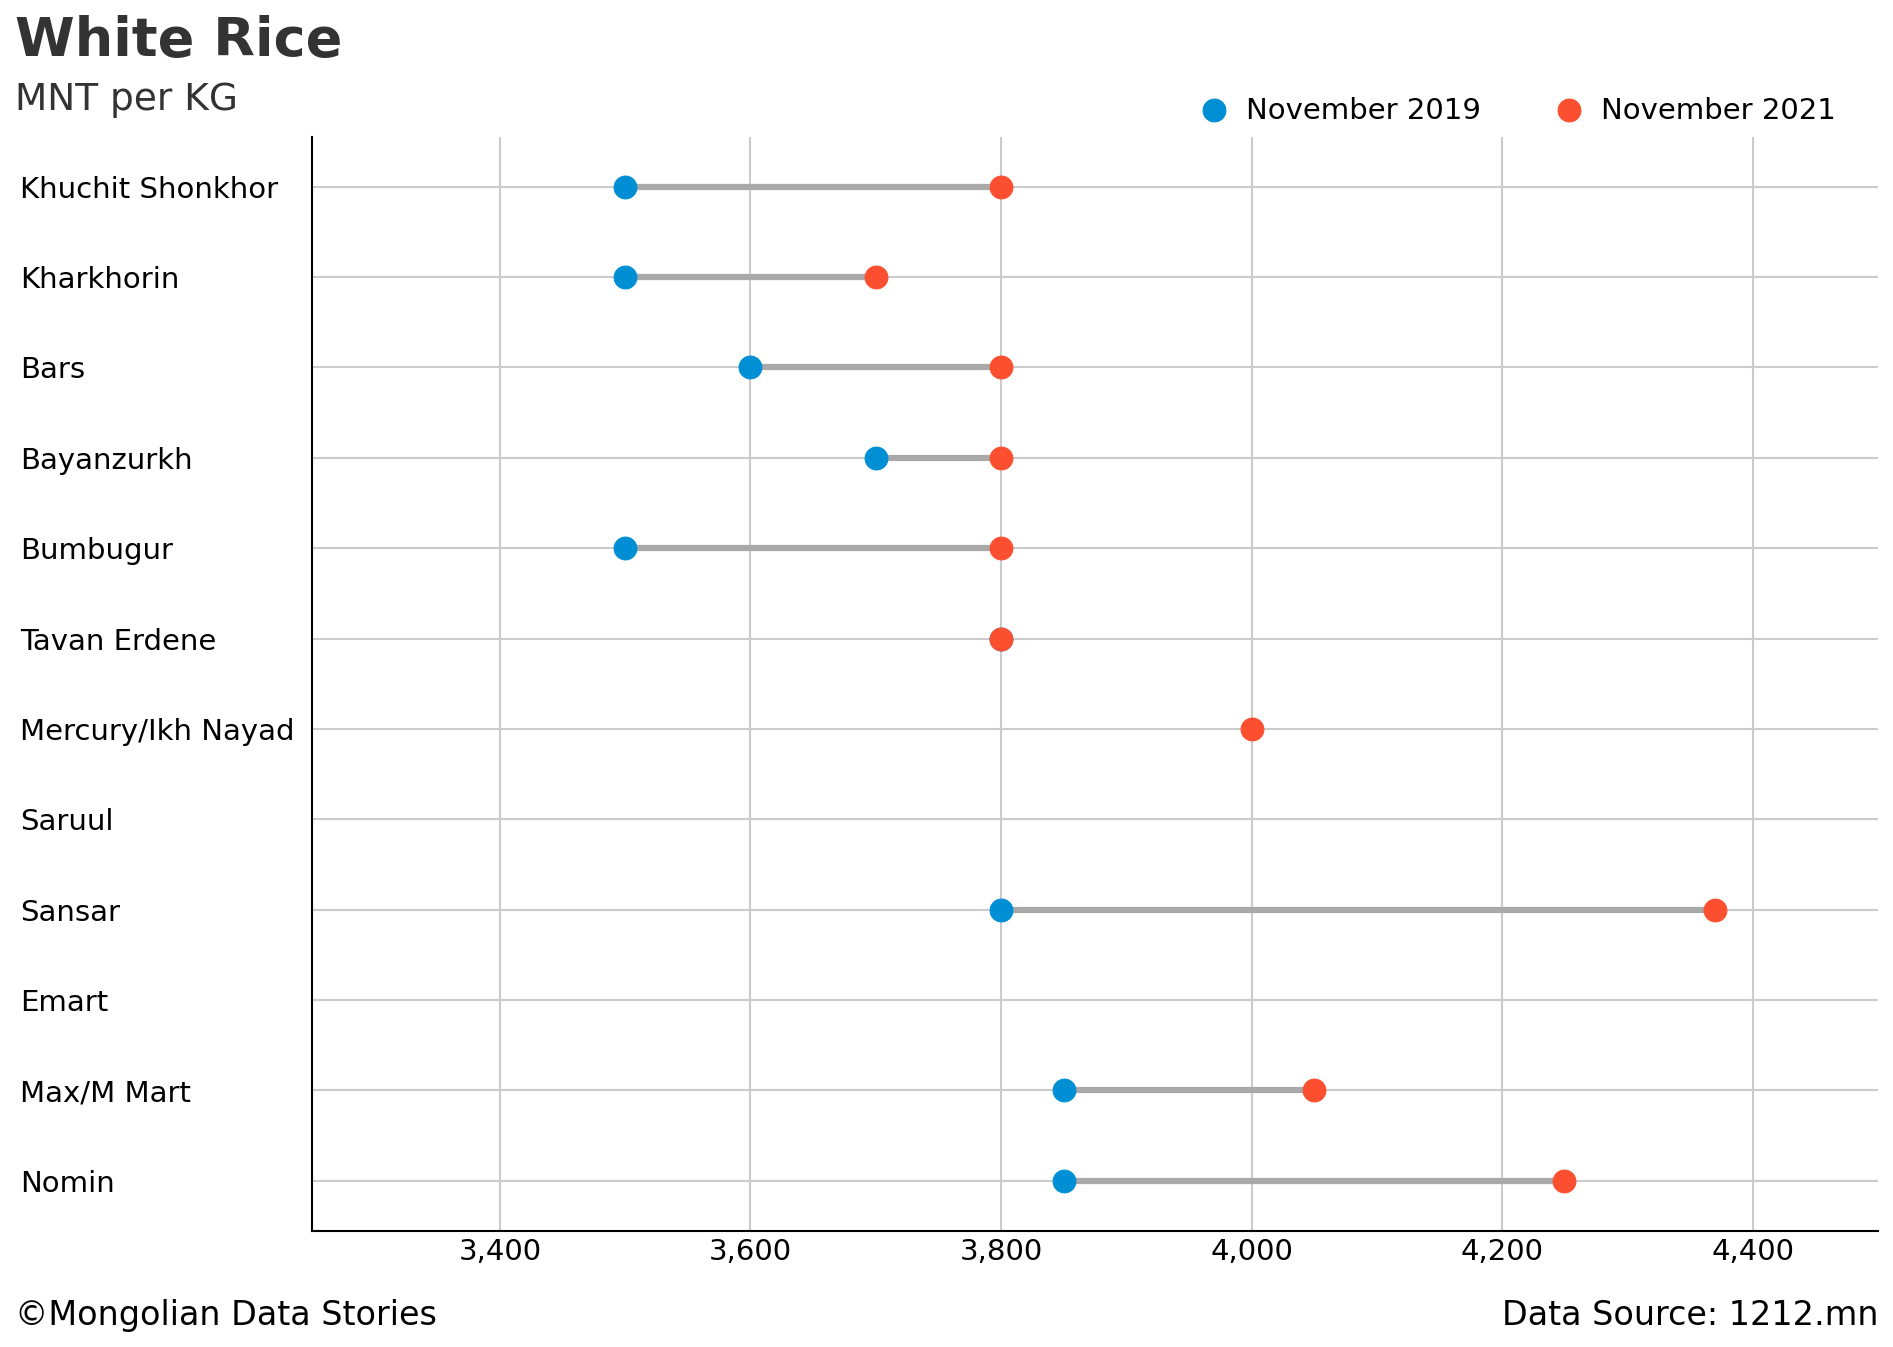

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'White Rice'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(3250, 4500)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="White Rice", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per KG", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/rice_dumbbell.png', dpi = 300, bbox_inches="tight")

### Талх Атар - Atar Brand Bread

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


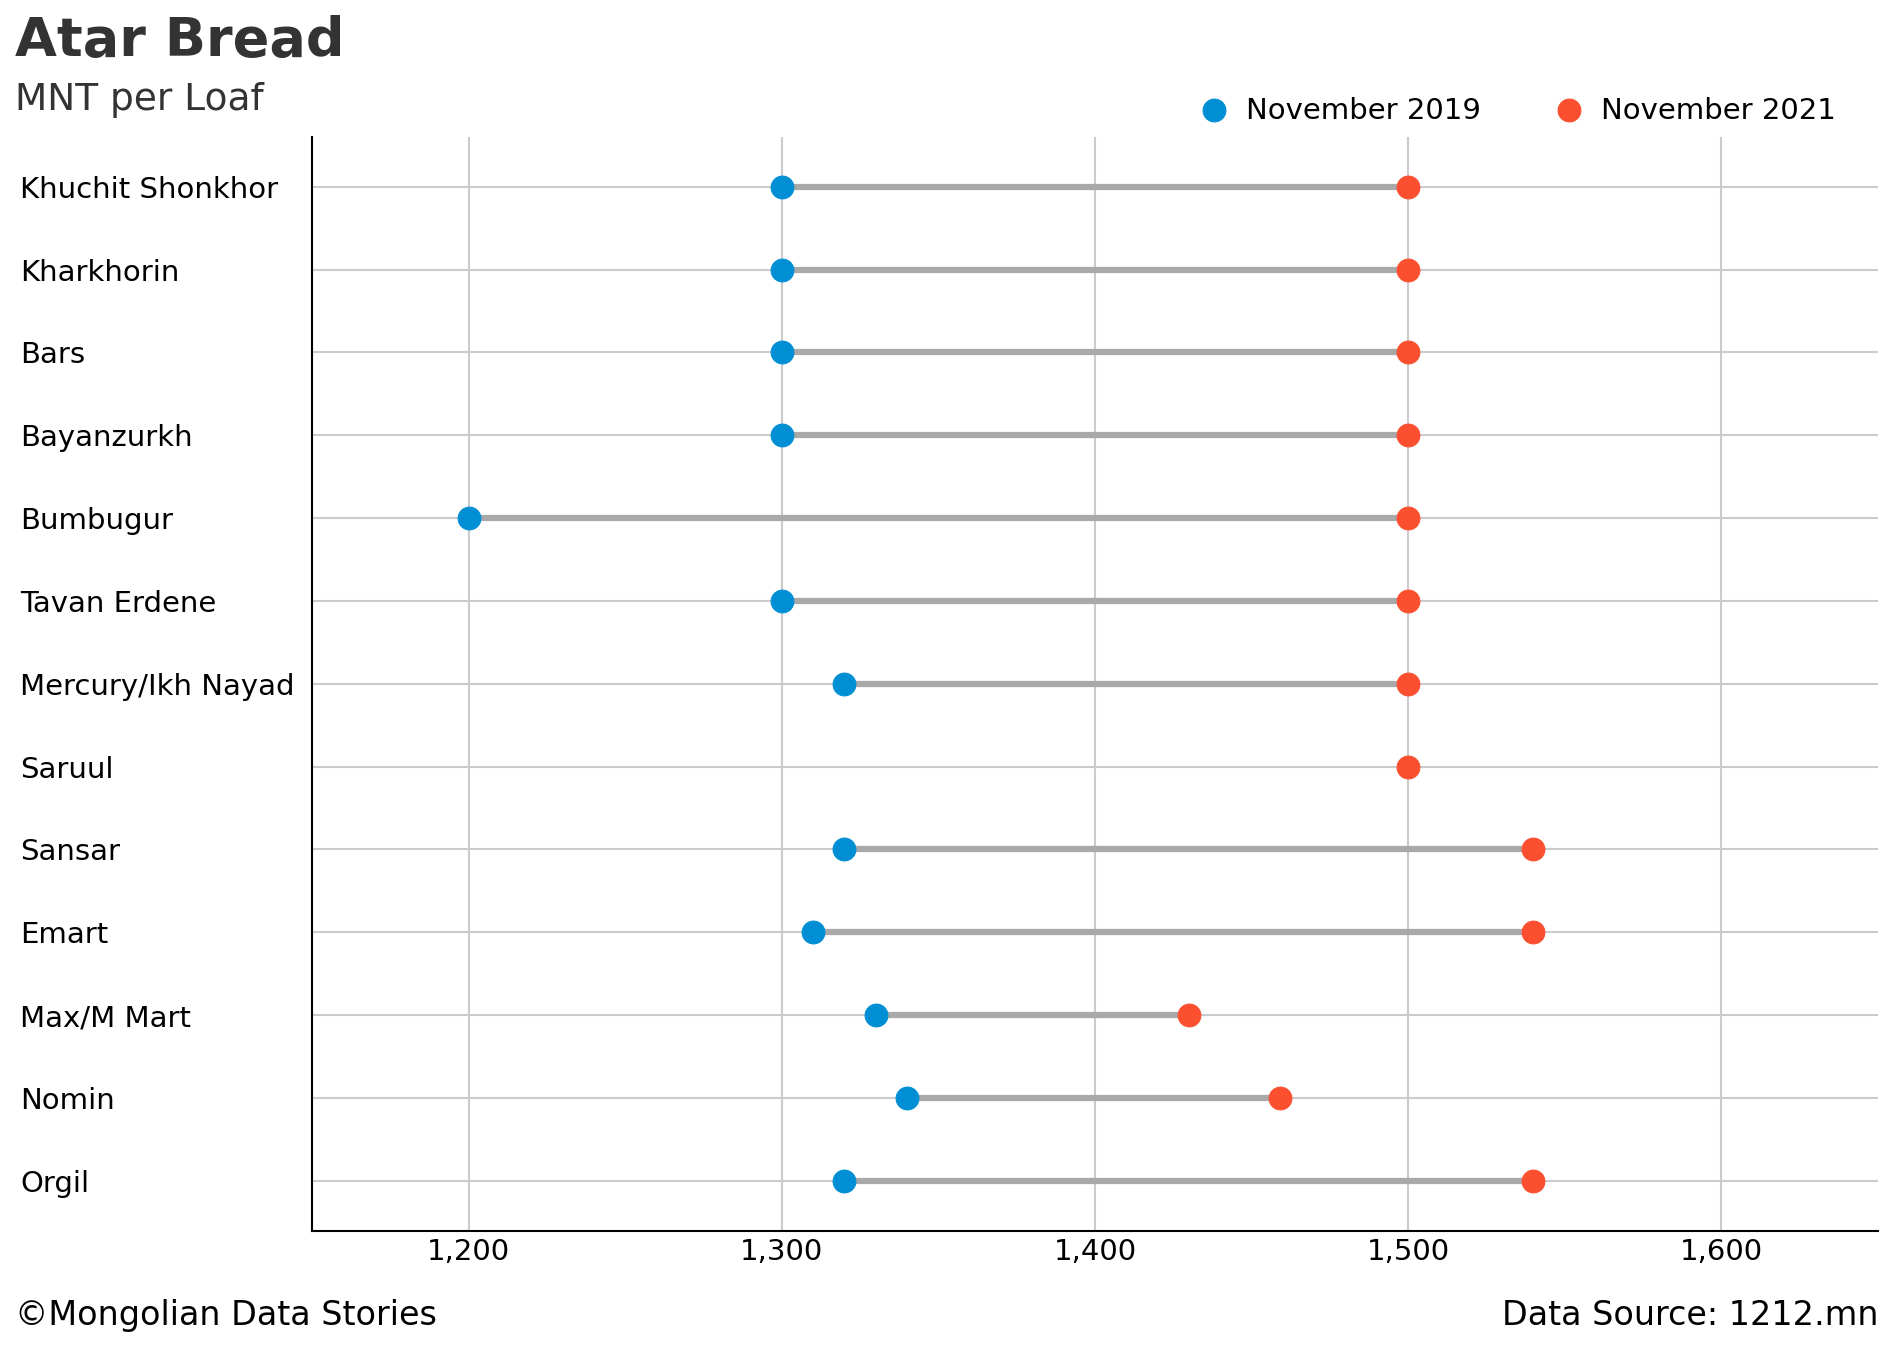

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Atar Brand Bread'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(1150, 1650)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')


# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Atar Bread", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per Loaf", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/bread_dumbbell.png', dpi = 300, bbox_inches="tight")

### Үхрийн мах ястай - Beef with Bones

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


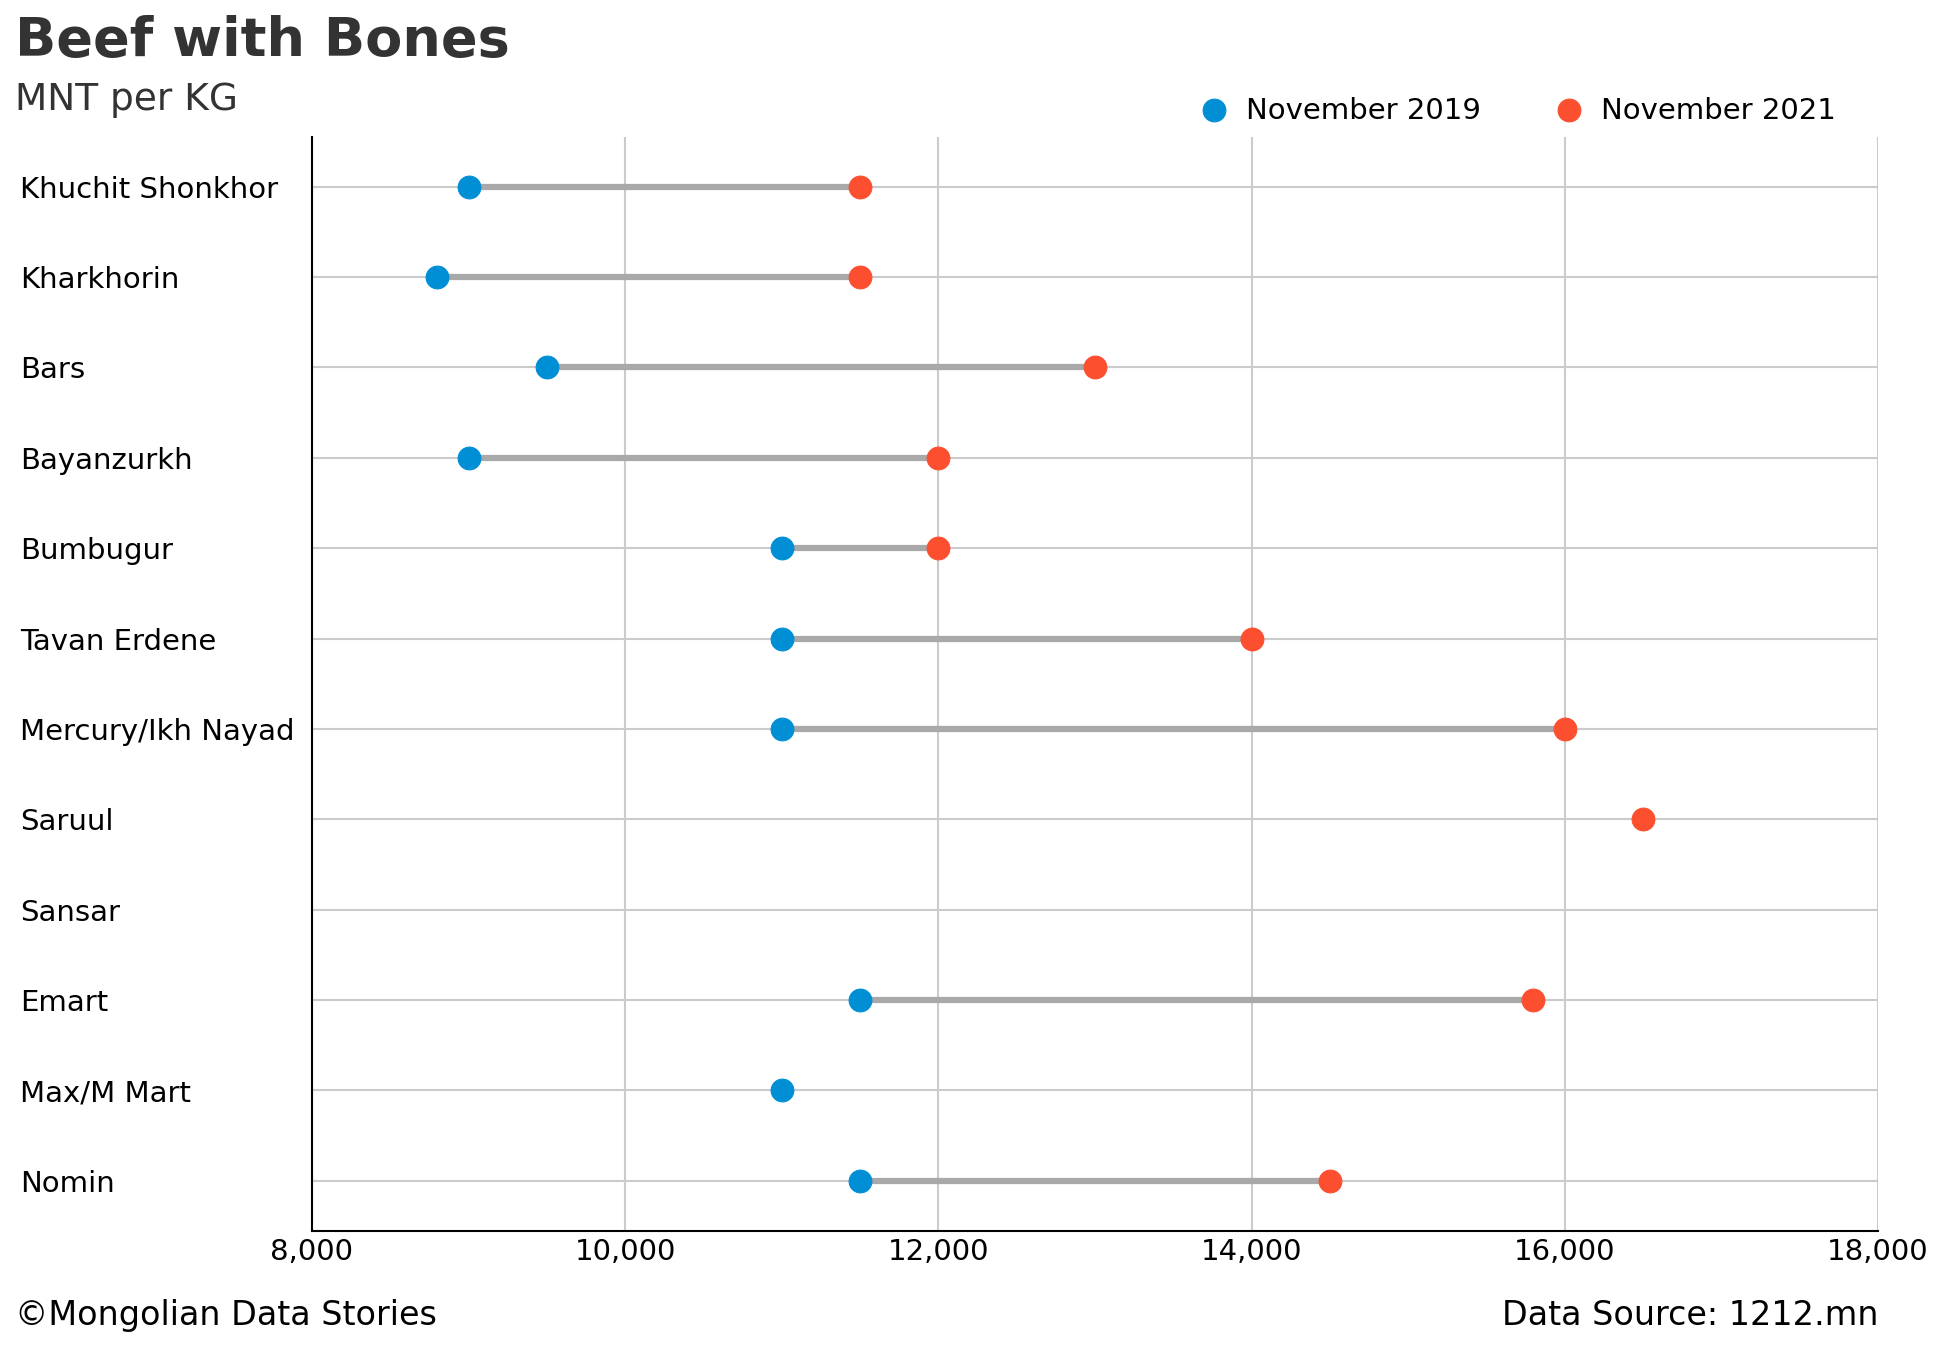

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Beef w/Bones'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(8000, 18000)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Beef with Bones", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per KG", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/beef_dumbbell.png', dpi = 300, bbox_inches="tight")

### Хонины мах ястай - Mutton with Bones

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


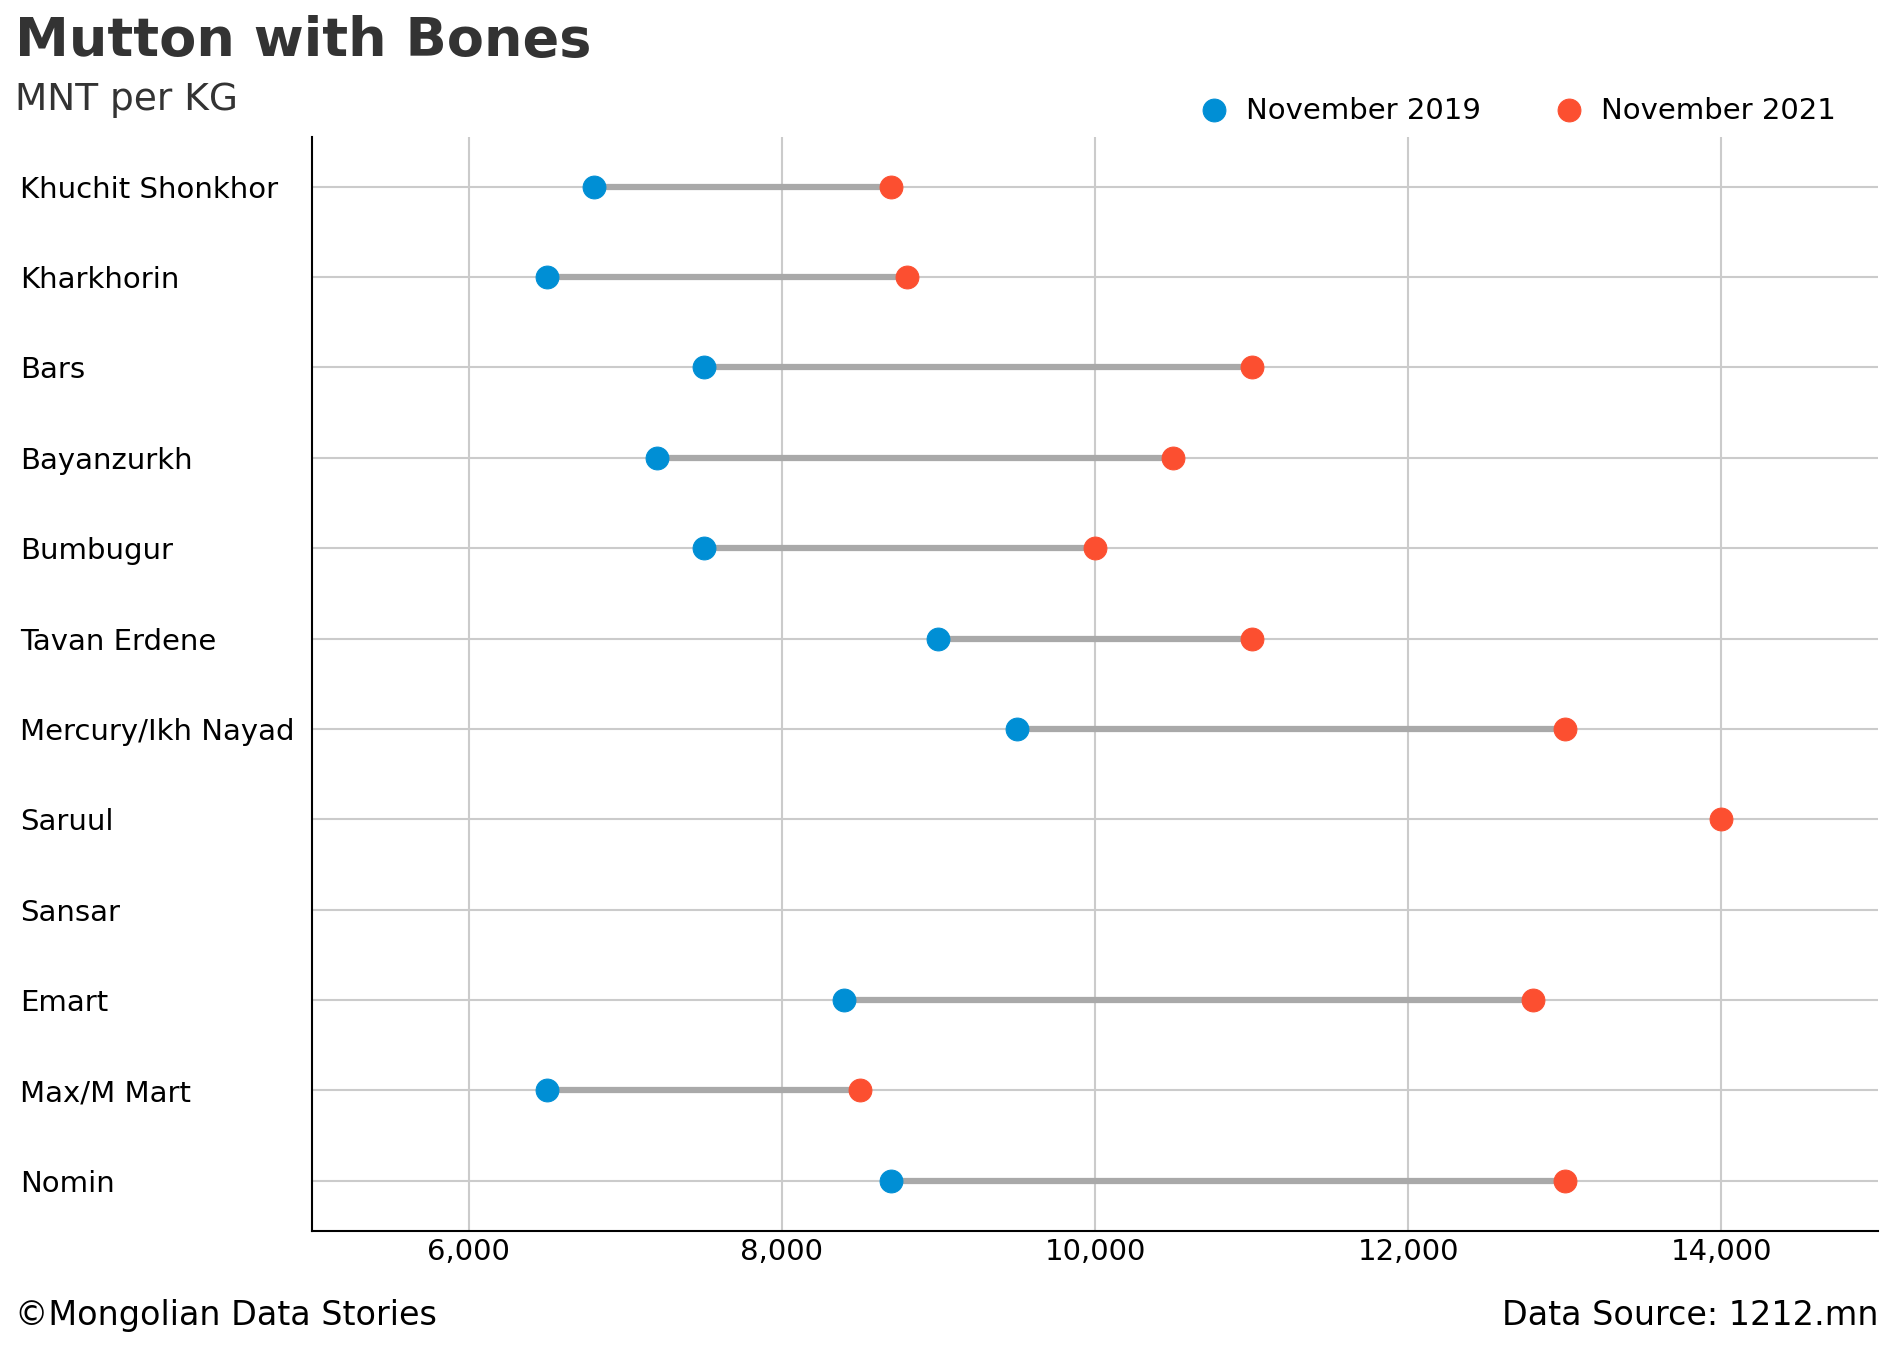

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# Set variables
product = 'Mutton w/Bones'
date1 = '2019-11-13'
date2 = '2021-11-17'
market_range = range(1, len(df['market'].unique())+1)

# Format Data
product_df = df[(df['product'] == product) & ((df['date'] == date1) | (df['date'] == date2))][['market','date','price']].pivot(index='market',columns='date', values='price')
product_df = product_df.groupby(product_df.index).max()
product_df = product_df.sort_index(key=lambda x: x.map(market_order), ascending=False)

# Plot lines and markers
ax.grid(visible=True, which='major', axis='both')
ax.hlines(y=product_df.index, xmin=product_df[date1], xmax=product_df[date2], color='darkgrey', zorder=1, linewidth=3, label='_nolegend_')
ax.scatter(product_df[date1], product_df.index, label='November 2019', s=120)
ax.scatter(product_df[date2], product_df.index, label='November 2021', s=120)

# Format axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(5000, 15000)
yax = ax.get_yaxis()
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad+140)
ax.set_yticklabels(product_df.index, ha = 'left')

# Set Legend
ax.legend(['November 2019', 'November 2021'], loc=(.55,1), ncol=2, frameon=False, handletextpad=.1, handleheight=1)

# Set title and subtitle
ax.text(x=-.085, y=.94, s="Mutton with Bones", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=-.085, y=.90, s="MNT per KG", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = -.085, y = 0, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .95, y = 0, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/mutton_dumbbell.png', dpi = 300, bbox_inches="tight")

## 2. How did COVID impact prices?

In [ ]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

In [ ]:
avg_df = df[df['product'].isin(product_list)].groupby(by=['product', 'date'], dropna=True).mean().reset_index()

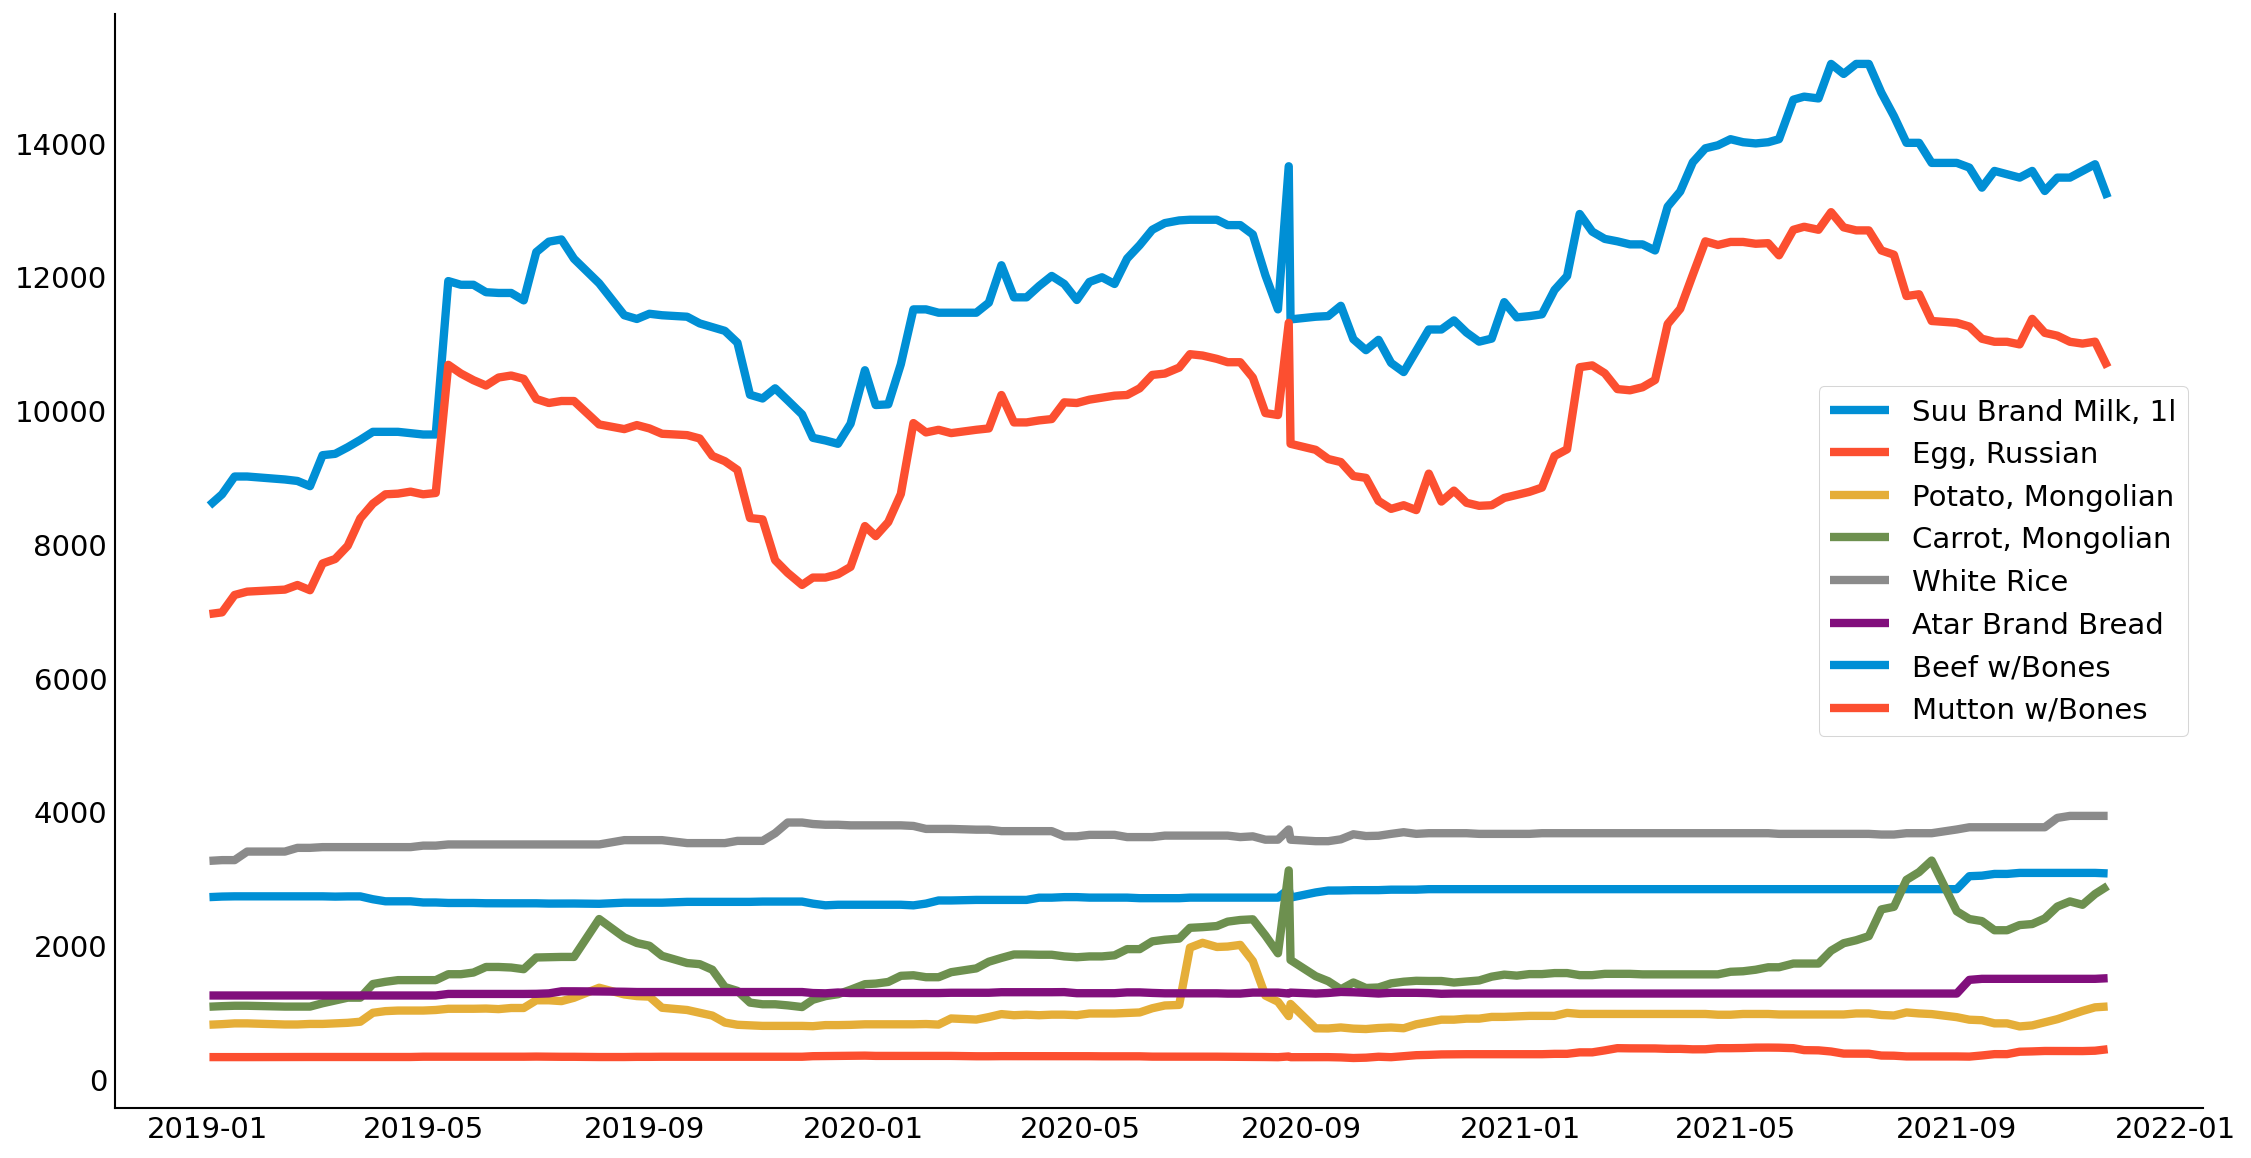

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

avg_df = df[df['product'].isin(product_list)].groupby(by=['product', 'date']).mean().reset_index()
x = avg_df['date'].unique()

for product in product_list:
    ax.plot(x, avg_df[avg_df['product'] == product]['price'], label=product)
ax.legend()

In [ ]:
product_list

['Suu Brand Milk, 1l',
 'Egg, Russian',
 'Potato, Mongolian',
 'Carrot, Mongolian',
 'White Rice',
 'Atar Brand Bread',
 'Beef w/Bones',
 'Mutton w/Bones']

In [ ]:
datetime.date(2020,8,1)

datetime.date(2020, 8, 1)

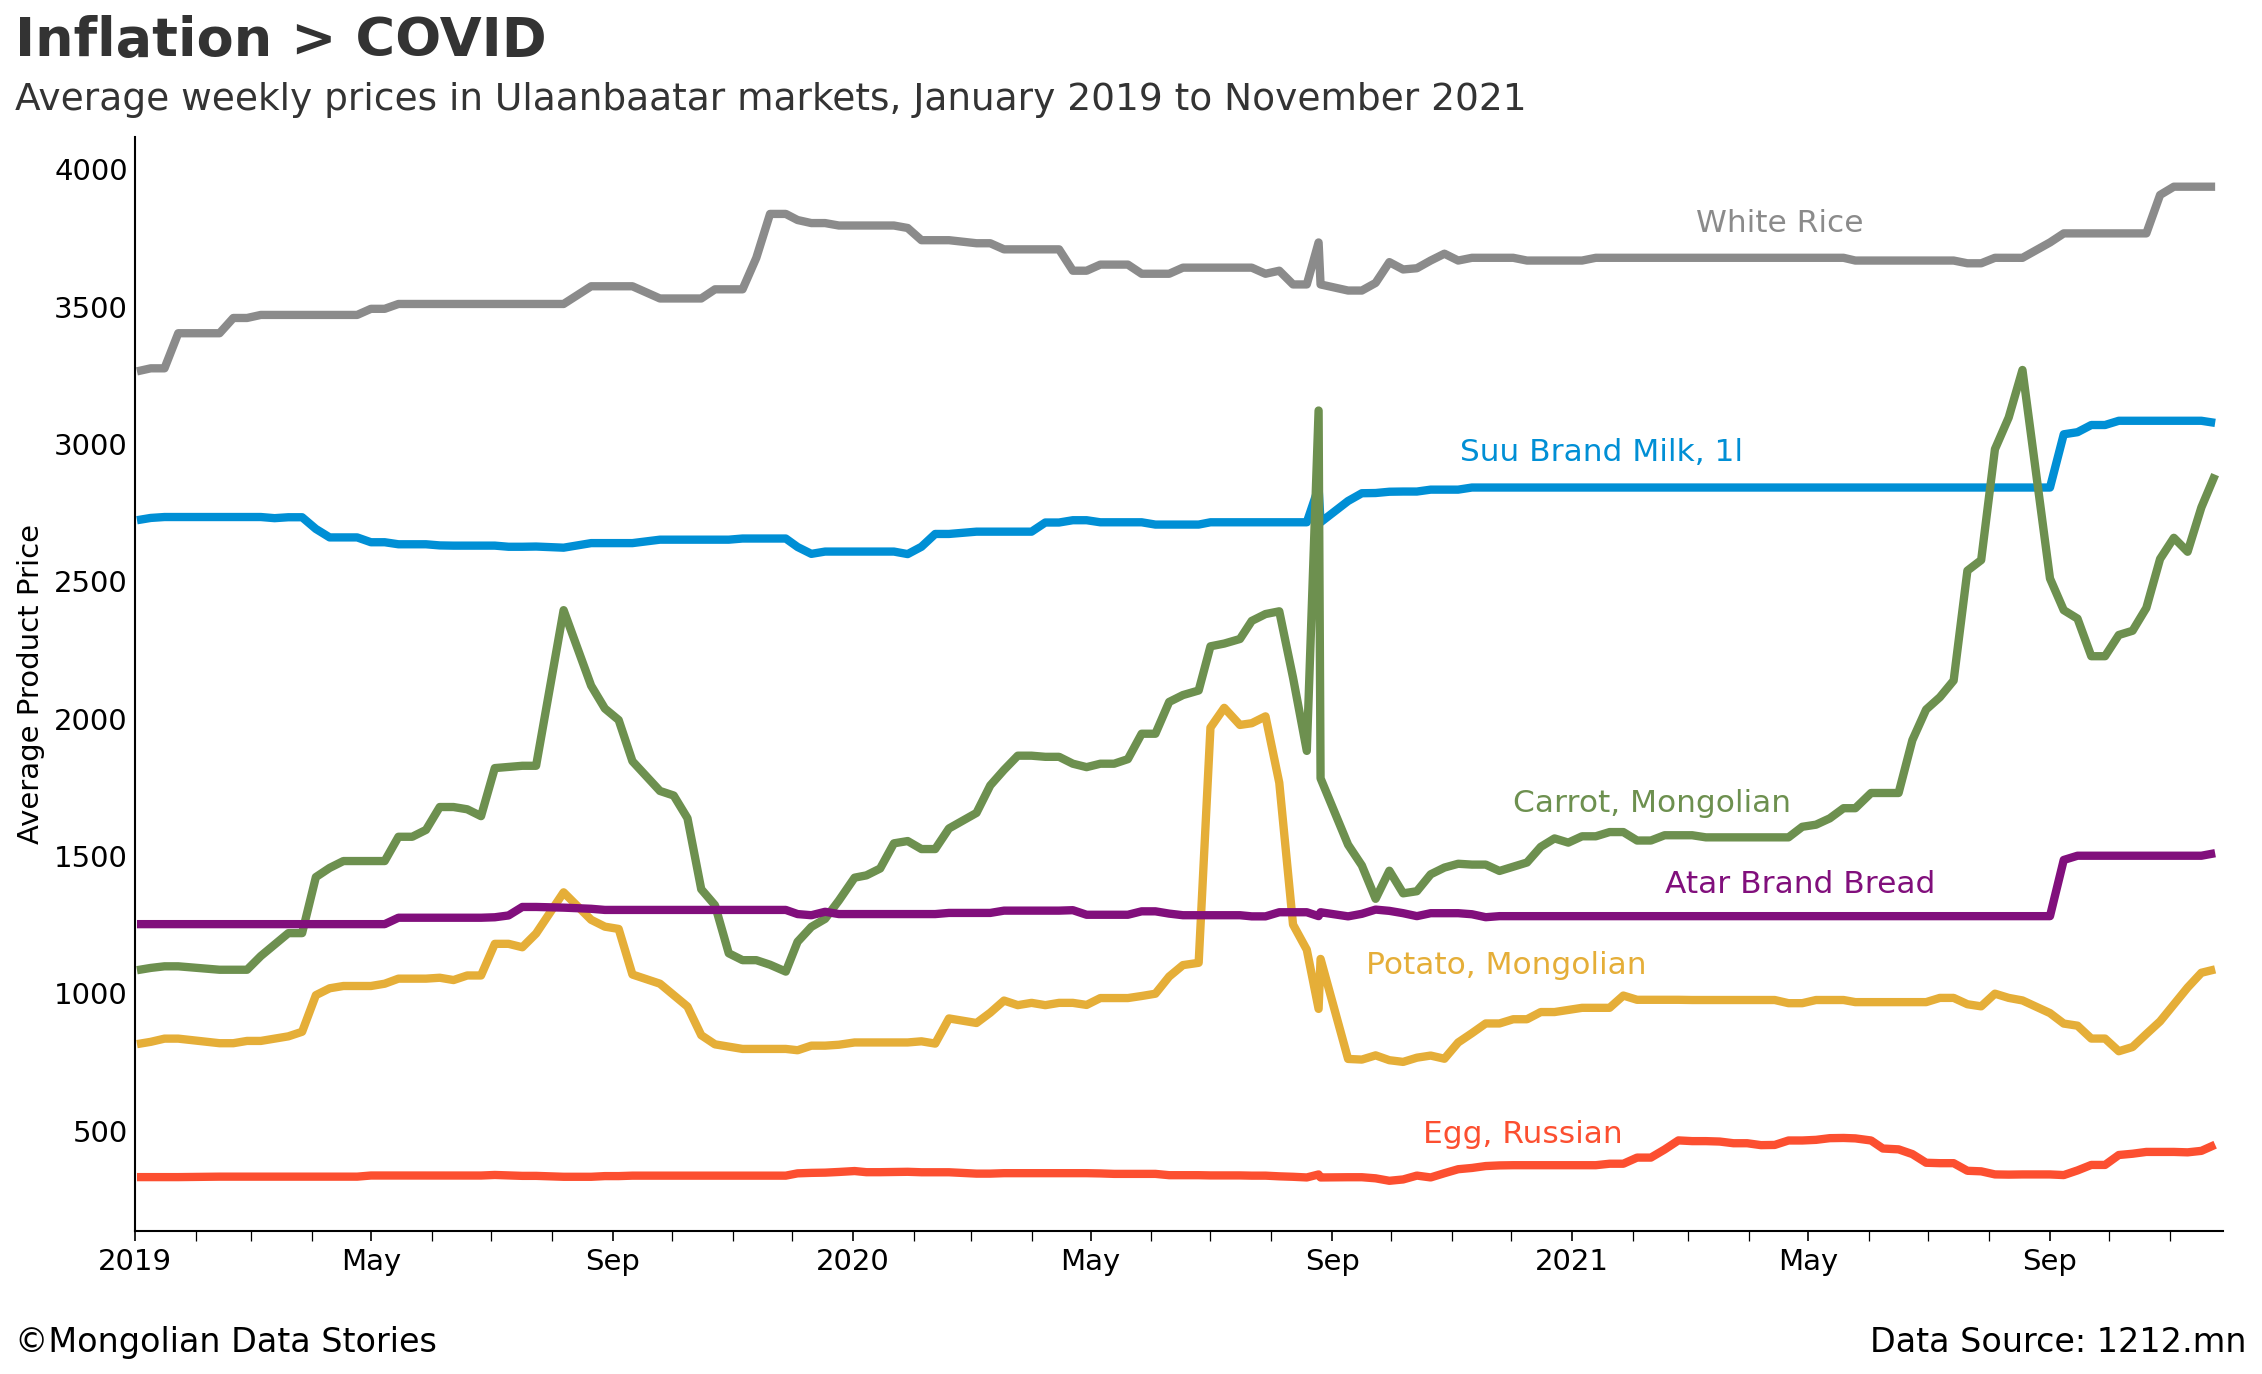

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

sub_list = ['Suu Brand Milk, 1l',
            'Egg, Russian',
            'Potato, Mongolian',
            'Carrot, Mongolian',
            'White Rice',
            'Atar Brand Bread',]

avg_df = df[df['product'].isin(sub_list)].groupby(by=['product', 'date']).mean().reset_index()
x = avg_df['date'].unique()

for product in sub_list:
    ax.plot(x, avg_df[avg_df['product'] == product]['price'], label=product)
ax.set_xlim(datetime.date(2019,1,1), datetime.date(2021,11,28))

# Set title and subtitle
ax.text(x=0.03, y=.94, s="Inflation > COVID", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.03, y=.90, s="Average weekly prices in Ulaanbaatar markets, January 2019 to November 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.03, y = -.02, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16)
ax.text(x = .96, y = -.02, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)

# Set axis label
ax.set_ylabel("Average Product Price") 

# Custom label formatting
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_minor_locator()))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='both', direction='out', length=5)

# Annotations
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.text(x = .75, y = .64, s = 'Suu Brand Milk, 1l', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[0])
ax.text(x = .7, y = .135, s = 'Egg, Russian', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[1])
ax.text(x = .71, y = .26, s = 'Potato, Mongolian', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[2])
ax.text(x = .77, y = .38, s = 'Carrot, Mongolian', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[3])
ax.text(x = .8, y = .81, s = 'White Rice', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[4])
ax.text(x = .83, y = .32, s = 'Atar Brand Bread', transform=fig.transFigure, ha='right', fontsize = 15, color=colors[5])

plt.savefig('images/inflation_covid.png', dpi = 300, bbox_inches="tight")

## 3. Do stores use psychological pricing?

In [ ]:
df['thousands'] = df['price'] % 1000 == 0

In [ ]:
df['hundreds'] = df['price'] % 100 == 0

In [ ]:
df['tens'] = df['price'] % 10 == 0

In [ ]:
end_price = df.groupby(by=['market']).sum().reset_index()

In [ ]:
end_price.head()

market         price  thousands  hundreds  tens
0        Bars  1.238332e+07        712      3777  4088
1  Bayanzurkh  1.490771e+07        882      4079  4342
2    Bumbugur  1.450671e+07        908      3765  4182
3       Emart  1.035435e+07         41       803  2811
4  Kharkhorin  1.535552e+07        835      4209  4517

In [ ]:
end_price = end_price.sort_values(by='thousands', ascending=False)

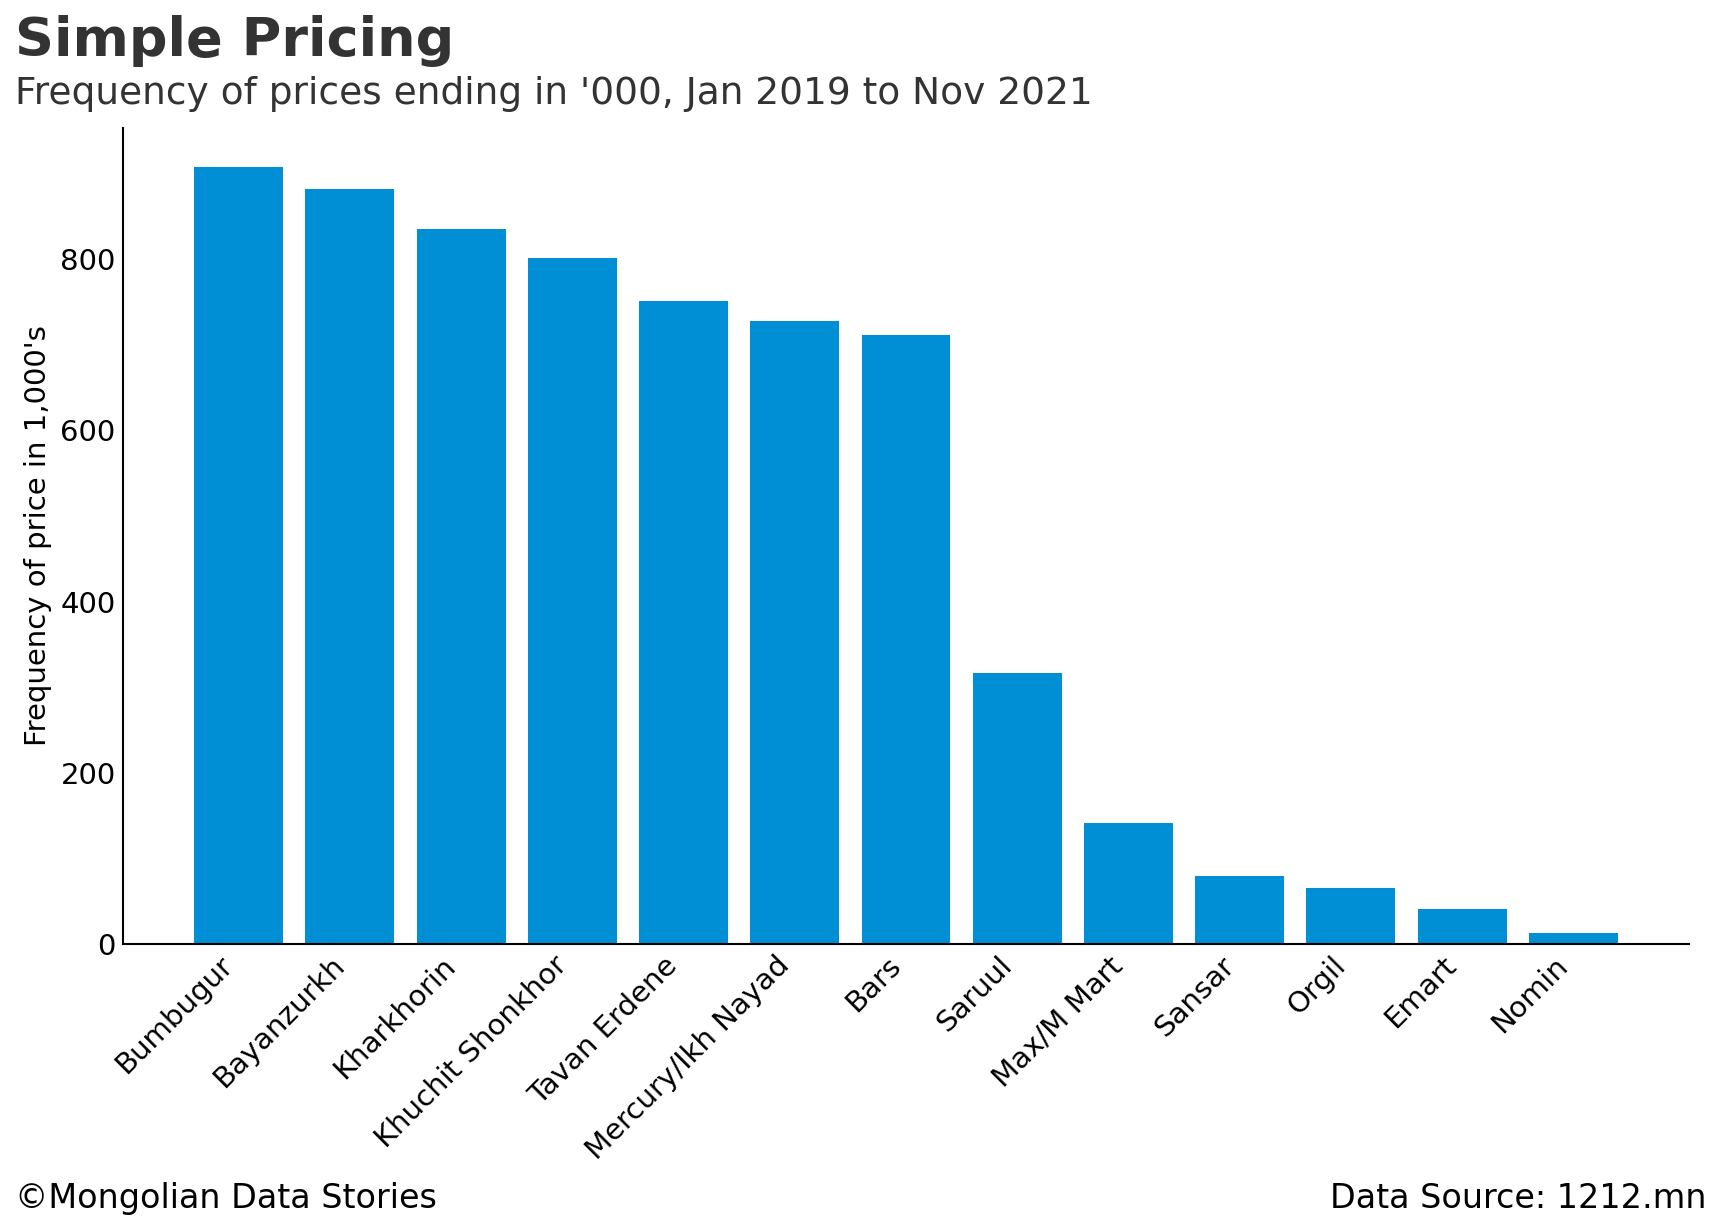

In [ ]:
fig, ax = plt.subplots()

ax.bar(end_price['market'], end_price['thousands'])

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Set axis labels
ax.set_ylabel("Frequency of price in 1,000's")    

# Set title and subtitle
ax.text(x=0.02, y=.94, s="Simple Pricing", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.02, y=.90, s="Frequency of prices ending in '000, Jan 2019 to Nov 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.02, y = -.02, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16, )
ax.text(x = .96, y = -.02, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/prices_thousands.png', dpi = 300, bbox_inches="tight")

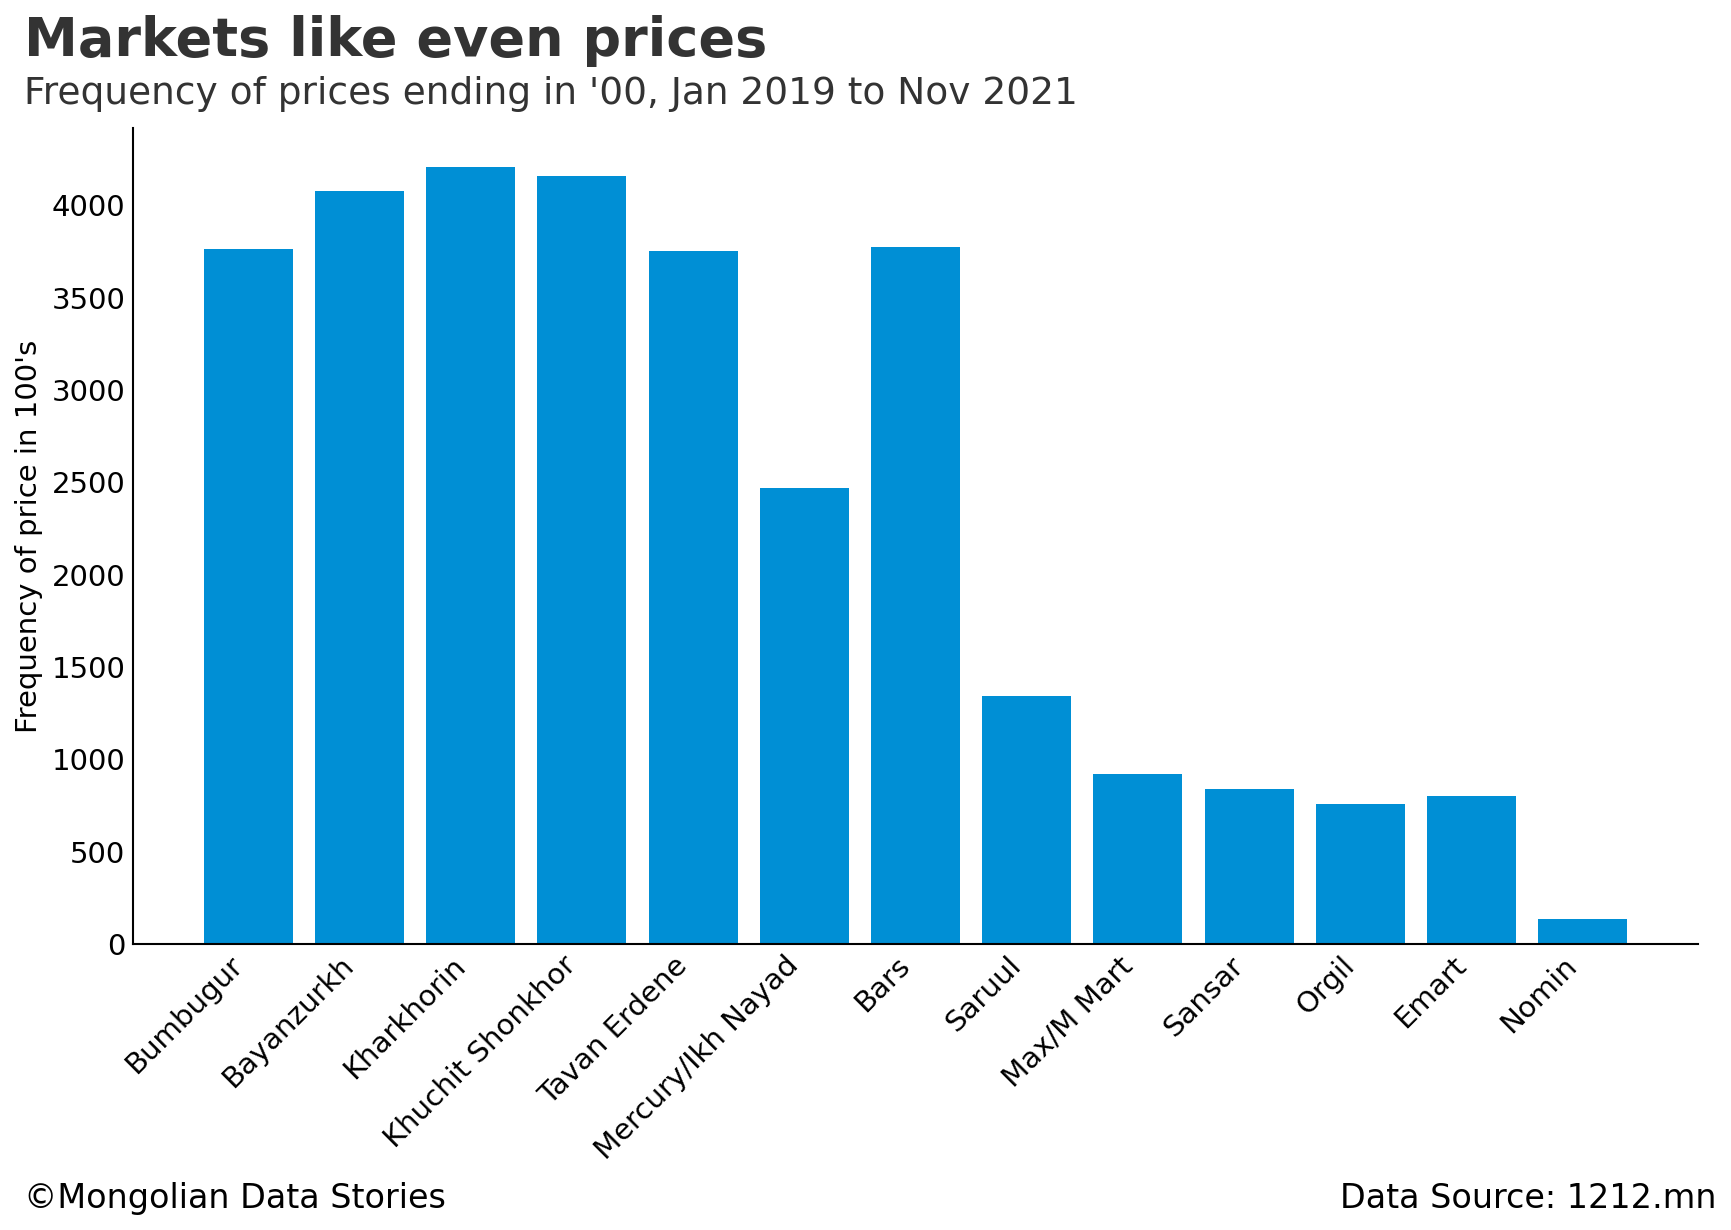

In [ ]:
fig, ax = plt.subplots()

ax.bar(end_price['market'], end_price['hundreds'])

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Remove axis labels
ax.set_ylabel("Frequency of price in 100's")    

# Set title and subtitle
ax.text(x=0.02, y=.94, s="Markets like even prices", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.02, y=.90, s="Frequency of prices ending in '00, Jan 2019 to Nov 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.02, y = -.02, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16, )
ax.text(x = .96, y = -.02, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/prices_hundreds.png', dpi = 300, bbox_inches="tight")

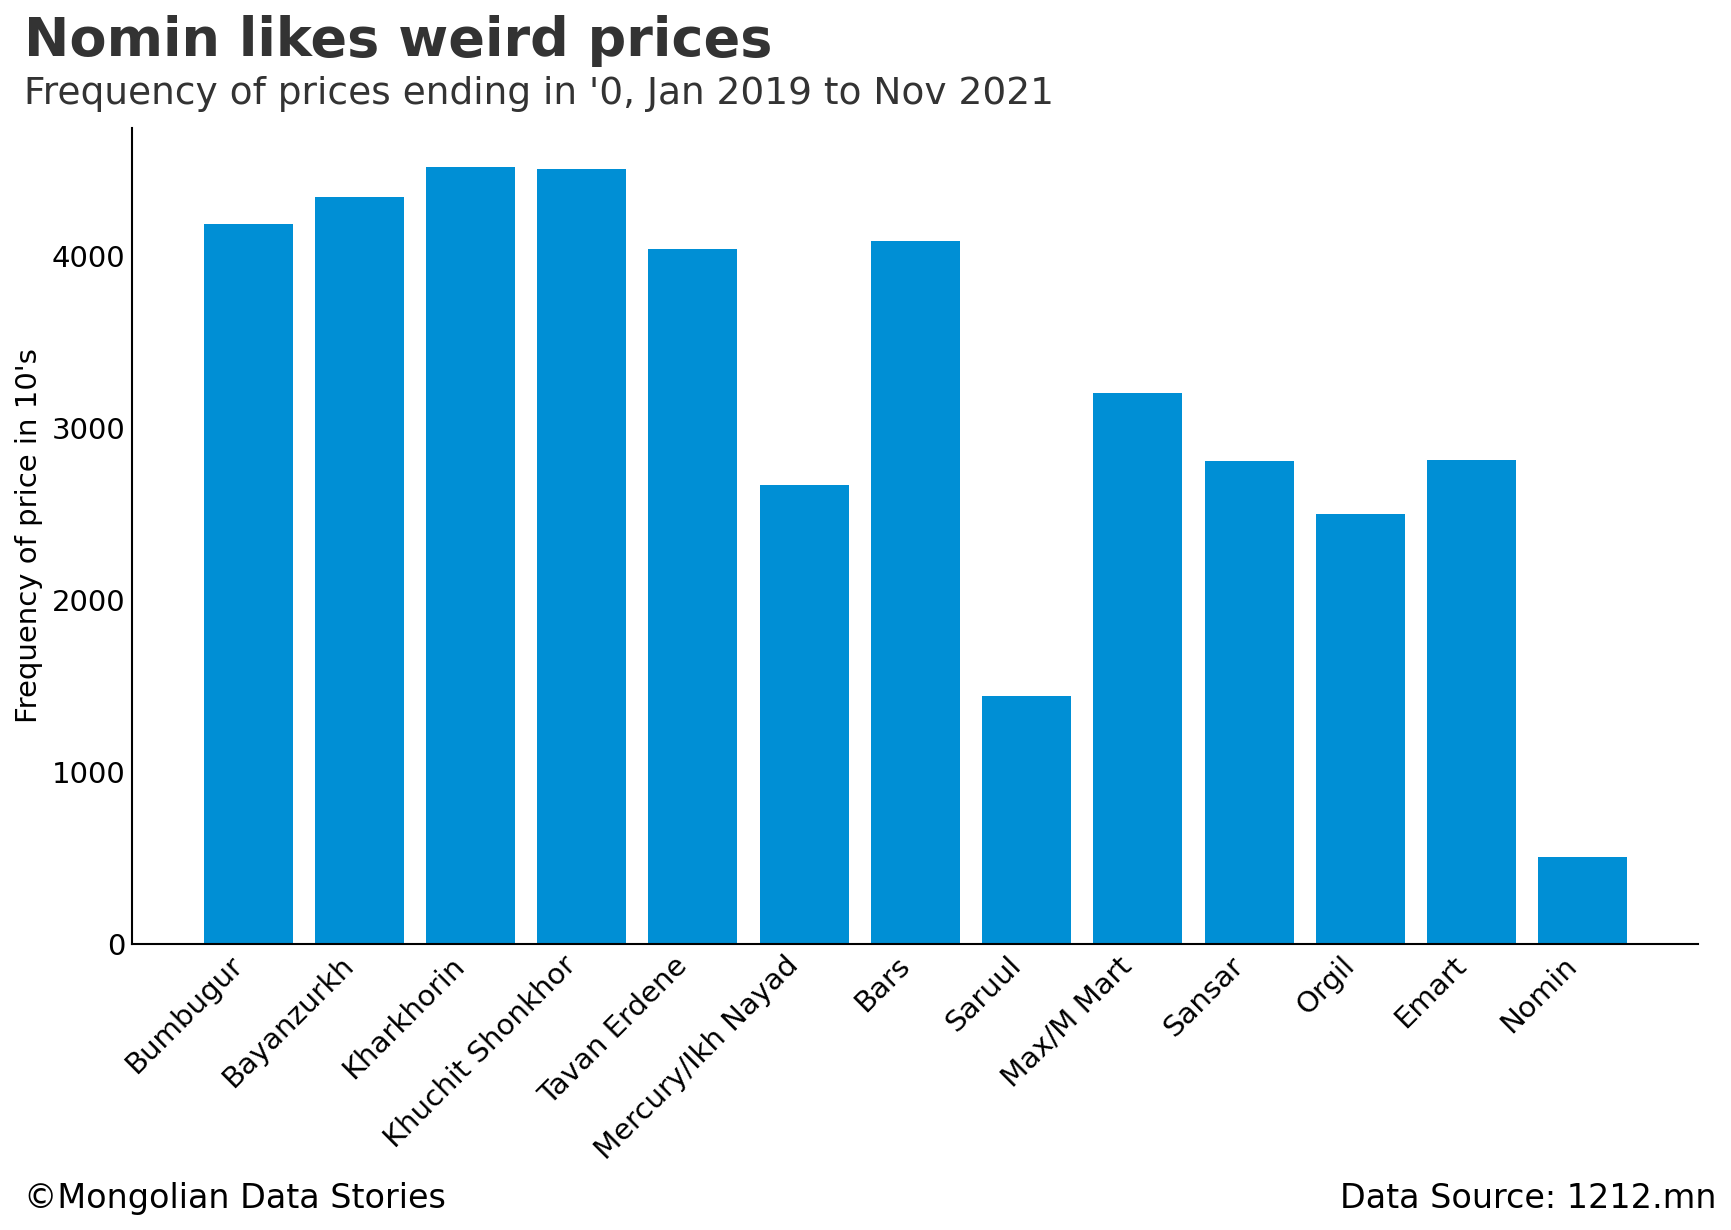

In [ ]:
fig, ax = plt.subplots()

ax.bar(end_price['market'], end_price['tens'])

# This nice trick works with text and dates. 
fig.autofmt_xdate(rotation=45)

# Remove axis labels
ax.set_ylabel("Frequency of price in 10's")    

# Set title and subtitle
ax.text(x=0.02, y=.94, s="Nomin likes weird prices", transform=fig.transFigure, ha='left', fontsize=26, weight='bold', alpha=.8)
ax.text(x=0.02, y=.90, s="Frequency of prices ending in '0, Jan 2019 to Nov 2021", transform=fig.transFigure, ha='left', fontsize=18, alpha=.8)

# Set bottom banner
ax.text(x = 0.02, y = -.02, s = '©Mongolian Data Stories', transform=fig.transFigure, ha='left', fontsize = 16, )
ax.text(x = .96, y = -.02, s = 'Data Source: 1212.mn', transform=fig.transFigure, ha='right', fontsize = 16)
plt.savefig('images/prices_tens.png', dpi = 300, bbox_inches="tight")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c29b651-5799-4ecf-8ca8-8e3f274961e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>